In [1]:
import numpy as np
import pandas as pd 
import pickle
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
import seaborn as sns
from scipy.signal import find_peaks, peak_widths

c:\Users\blanc\miniconda3\envs\adaexam\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Load Fiber photometry 
with open( "../dopamine/Data/Expert_mice/all_processed_Sanity.pkl", "rb") as f:
    data = pickle.load(f)
iso_corrected = data['Rico']['corrected_data_iso']

# Load behavior
behavior = np.load('../dopamine/Data/Expert_mice/Rico2_unrolled_SJ.npy')

In [ ]:
# Global variables
fs_iso = 20.0  
fs_beh = 30.0 
rois = [8, 9, 14]    # [0, 1, 5, 8, 9, 14]
n_iso = len(iso_corrected)
n_beh = behavior.shape[1]
t_iso = np.arange(n_iso) / fs_iso
t_beh = np.arange(n_beh) / fs_beh
columns_beh = ['snout_x', 'snout_y', 'rightear_x', 'rightear_y', 'leftear_x', 'leftear_y', 'tailbase_x', 'tailbase_y', 'trail_x', 'trail_y'] 
columns_roi = ['ROI_8', 'ROI_9', 'ROI_14']


### Behavior Data: Visualization and Processing

##### Load and Fill NaN


In [4]:
behavior_df = pd.DataFrame(behavior.T, columns=columns_beh)

for col in columns_beh:
    s = behavior_df[col]
    prev = s.ffill()   # nearest value before
    nxt  = s.bfill()   # nearest value after

    mask = s.isna()

    # both neighbors available -> average
    both = mask & prev.notna() & nxt.notna()
    behavior_df.loc[both, col] = (prev[both] + nxt[both]) / 2

    # only one neighbor available -> use that neighbor
    only_prev = mask & prev.notna() & nxt.isna()
    only_next = mask & prev.isna()  & nxt.notna()
    behavior_df.loc[only_prev, col] = prev[only_prev]
    behavior_df.loc[only_next, col] = nxt[only_next]


behavior_df['t_s'] = np.arange(len(behavior_df)) / fs_beh

print(behavior_df.shape)

(9743, 11)


##### Visualize trajectories

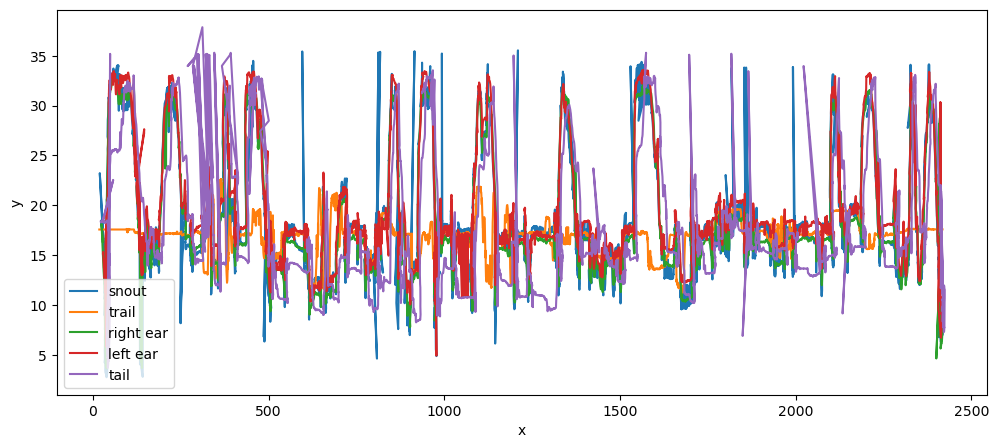

In [5]:
fig, ax = plt.subplots(figsize=(12, 5))
ax.plot(behavior_df['snout_x'].values, behavior_df['snout_y'].values, label='snout')
ax.plot(behavior_df['trail_x'].values, behavior_df['trail_y'].values, label='trail')
ax.plot(behavior_df['rightear_x'].values, behavior_df['rightear_y'].values, label='right ear')
ax.plot(behavior_df['leftear_x'].values, behavior_df['leftear_y'].values, label='left ear')
ax.plot(behavior_df['tailbase_x'].values, behavior_df['tailbase_y'].values, label='tail')

ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()

plt.show()

##### x and y trajectories as a function of time

Alomost linear along x

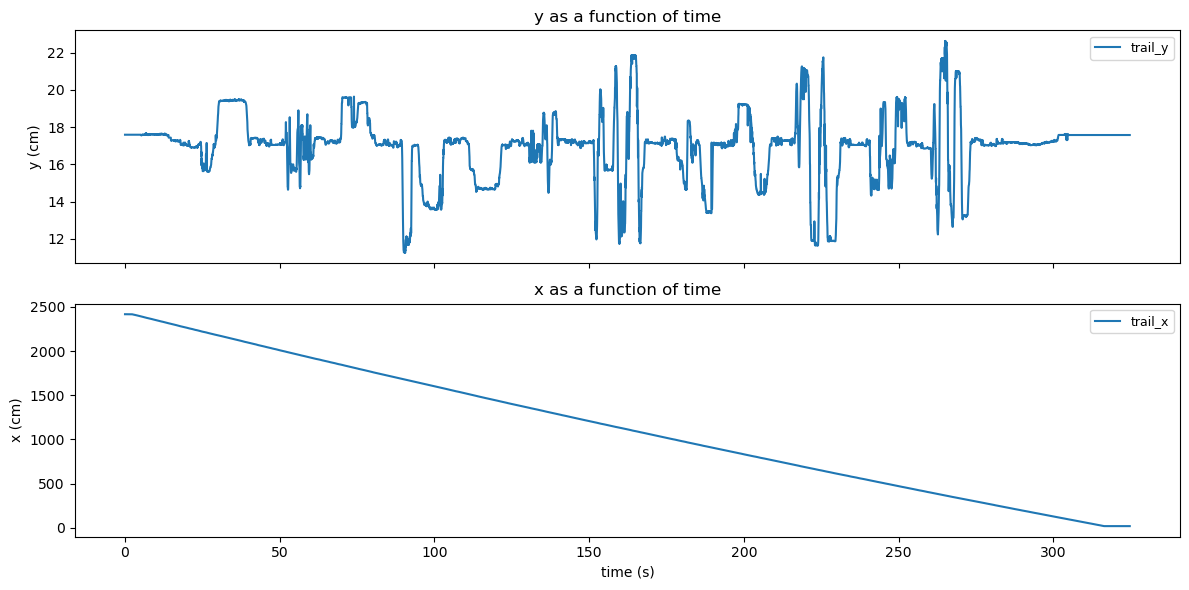

In [6]:
parts = ['trail']  #['snout', 'rightear', 'leftear', 'tailbase', 'trail']  
y_cols = [f'{p}_y' for p in parts]
x_cols = [f'{p}_x' for p in parts]

time_window = None  
t = behavior_df['t_s'].to_numpy()

if time_window is not None:
    t0, t1 = time_window
    base_mask = (t >= t0) & (t < t1)
    t_plot = t[base_mask]
else:
    base_mask = np.isfinite(t)
    t_plot = t[base_mask]

fig, axes = plt.subplots(2, 1, figsize=(12, 6), sharex=True)
ax_y, ax_x = axes

# y(t)
for col in y_cols:
    y = behavior_df[col].to_numpy()
    m = base_mask & np.isfinite(y)
    ax_y.plot(t[m], y[m], label=col)
ax_y.set_ylabel('y (cm)')
ax_y.set_title('y as a function of time')
ax_y.legend(ncol=3, fontsize=9)

# x(t)
for col in x_cols:
    x = behavior_df[col].to_numpy()
    m = base_mask & np.isfinite(x)
    ax_x.plot(t[m], x[m], label=col)
ax_x.set_xlabel('time (s)')
ax_x.set_ylabel('x (cm)')
ax_x.set_title('x as a function of time')
ax_x.legend(ncol=3, fontsize=9)

plt.tight_layout()
plt.show()


##### Correct Artefacts

From the above plot, the large 30cm transients that occur within a frame are likely artefacts: unlikely that the mouse's snout moves of 30cm in 0.03s. 

Methodology: 
1) Flag frames whose per-step jump exceeds a physical limit (v_max_physical/fs), whose speed is a robust outlier (|speed - median| > k*MAD, with std fallback), or whose absolute speed > v_max_physical.
2) Expand the outlier mask to neighbors (±1 frame) to catch needle spikes.
3) Remove & repair: set flagged samples to NaN, then linearly interpolate only short interior gaps (≤ interp_limit_s). Long gaps remain NaN.
4) Light denoising: median filter (smooth_win) on the repaired series.
5) Restore original values at all non-flagged frames so only flagged points are replaced.

In [7]:
dt = 1/fs_beh

def clean_track(y, fs=30.0, v_max_physical=120.0, interp_limit_s=0.5, edge_fill_s=0.5, smooth_win=5, k=6.0, preserve_good=True):
    y = pd.Series(y, dtype=float)
    if y.notna().sum() < 2:
        return y, pd.Series(False, index=y.index)

    dy = y.diff()
    speed = dy * fs

    med = np.nanmedian(speed)
    mad = np.nanmedian(np.abs(speed - med))
    if not np.isfinite(mad) or mad == 0:
        std = np.nanstd(speed)
        robust_thr = k * std if np.isfinite(std) and std > 0 else np.inf
    else:
        robust_thr = k * 1.4826 * mad

    frame_jump_max = v_max_physical / fs
    outlier = ((np.abs(dy) > frame_jump_max) | (np.abs(speed - med) > robust_thr) | (np.abs(speed) > v_max_physical))
    
    outlier = outlier.astype(bool)
    outlier = (outlier | outlier.shift(1, fill_value=False) | outlier.shift(-1, fill_value=False))

    y_masked = y.mask(outlier)
    y_filled = y_masked.interpolate(limit=int(fs*interp_limit_s), limit_direction='both')

    # bounded edge fill for short head/tail gaps
    edge_lim = int(fs*edge_fill_s)
    #if edge_lim > 0:
    y_filled = y_filled.bfill(limit=edge_lim).ffill(limit=edge_lim)

    if smooth_win and smooth_win > 1:
        y_smooth = y_filled.rolling(smooth_win, center=True, min_periods=1).median()
    else:
        y_smooth = y_filled

    y_clean = y.where(~outlier, y_smooth) if preserve_good else y_smooth
    return y_clean, outlier


cols_to_clean = ['snout_y','rightear_y', 'leftear_y', 'tailbase_y', 'trail_y']
# per-track physical speed limits (cm/s); tweak if you like
vmax = {
    'snout_y': 120.0,
    'rightear_y': 120.0,
    'leftear_y': 120.0,
    'tailbase_y': 120.0,
    'trail_y': 120.0,
}

raw_backup = behavior_df[cols_to_clean].copy()

cleaned = {}
outliers = {}
for col in cols_to_clean:
    if col not in behavior_df.columns:
        print(f"[skip] {col} not in behavior_df")
        continue
    y_raw = behavior_df[col].astype(float)
    y_clean, mask = clean_track(y_raw, fs=fs_beh, v_max_physical=vmax.get(col, 120.0))
    cleaned[col] = y_clean
    outliers[col] = mask
    behavior_df[col] = y_clean 

to_drop = [f"{c}_clean" for c in cols_to_clean if f"{c}_clean" in behavior_df.columns]
if to_drop:
    behavior_df.drop(columns=to_drop, inplace=True)


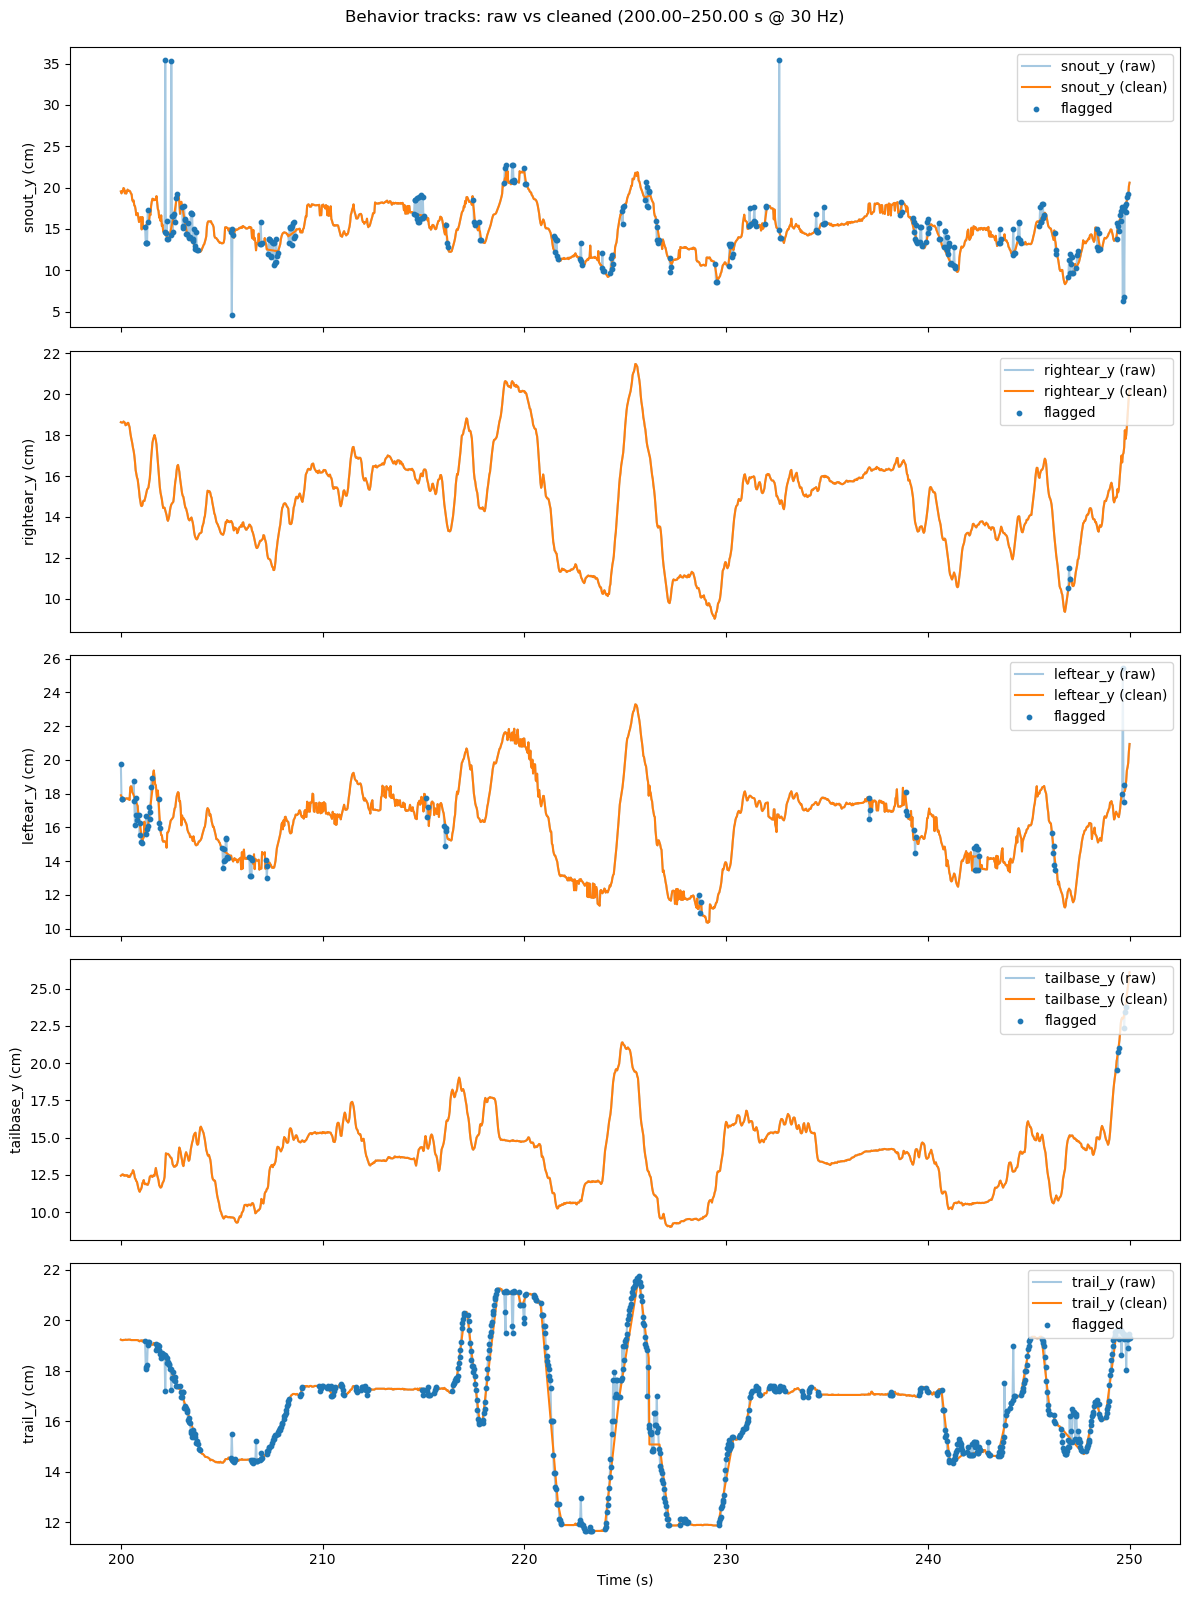

In [8]:
cols_present = [c for c in cols_to_clean if c in behavior_df.columns]
t0, t1 = 200.0,250.0
N = len(behavior_df); t = np.arange(N) / fs_beh
i0 = t.searchsorted(max(0.0, t0), side='left')
i1 = t.searchsorted(min(t1, (N-1)/fs_beh), side='right'); sl = slice(i0, i1)

nrows = len(cols_present)
fig, axes = plt.subplots(nrows, 1, figsize=(12, 3.2*nrows), sharex=True)
if nrows == 1: axes = [axes]

for ax, col in zip(axes, cols_present):
    y_raw = raw_backup[col].astype(float)
    y_cln = behavior_df[col].astype(float)
    m = outliers[col]

    tt = t[sl]
    ax.plot(tt, y_raw.iloc[sl],  alpha=0.4, label=f'{col} (raw)')
    ax.plot(tt, y_cln.iloc[sl], linewidth=1.5, label=f'{col} (clean)')
    ax.scatter(tt[m.iloc[sl]], y_raw.iloc[sl][m.iloc[sl]], s=10, label='flagged', zorder=3)
    ax.set_ylabel(f'{col} (cm)'); ax.legend(loc='upper right')

axes[-1].set_xlabel('Time (s)')
fig.suptitle(f'Behavior tracks: raw vs cleaned ({t0:.2f}–{t1:.2f} s @ {fs_beh:.0f} Hz)', y=0.995)
plt.tight_layout(); plt.show()


### Fiberphotometry data: Visualization and Processing

##### Sanity Plots 

The original list of rois thta were supposed to give decent signals was 0, 1, 5, 8, 9, 14. But after plotting only 8,9,14 give clean signals.

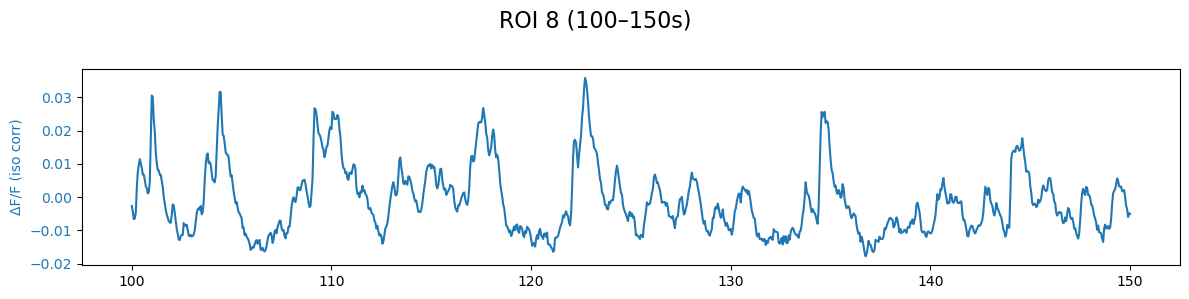

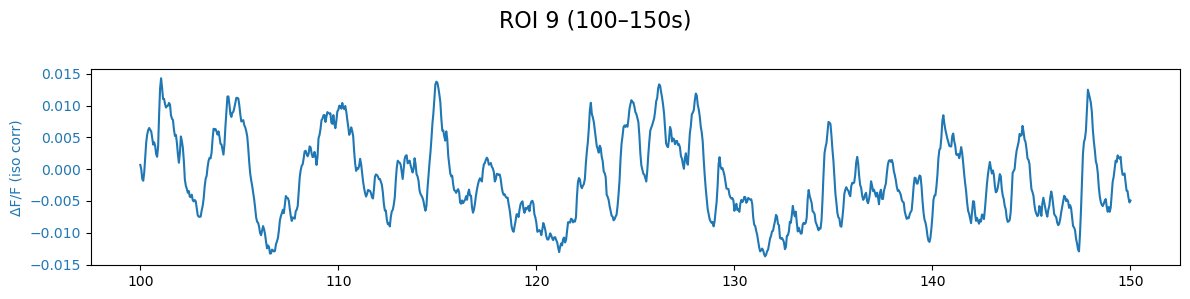

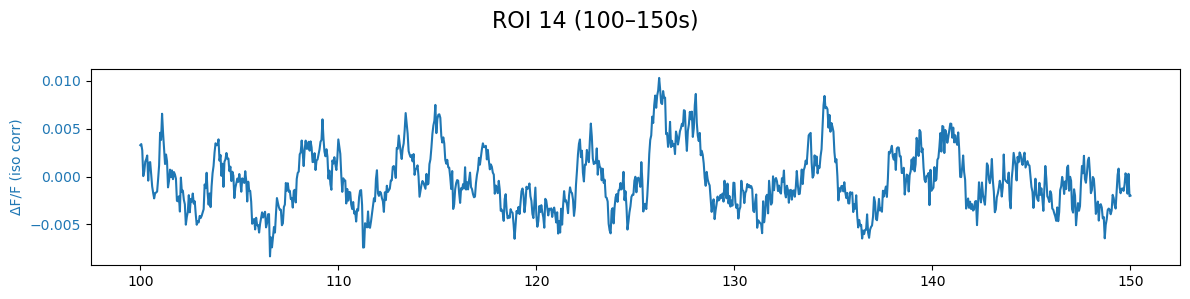

In [9]:
for roi in rois:
    
    iso = iso_corrected[:,roi],
    
    start_sec, end_sec =100,150
    mask = (t_iso >= start_sec) & (t_iso <= end_sec)

    fig, axes = plt.subplots(1, 1, figsize=(12, 3), sharex=True)

    axes.plot(t_iso[mask], iso[0][mask], color='tab:blue')
    axes.set_ylabel('ΔF/F (iso corr)', color='tab:blue')
    axes.tick_params(axis='y', labelcolor='tab:blue')

    fig.suptitle(f'ROI {roi} ({start_sec}–{end_sec}s)', fontsize=16)
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()


##### Upsample to Behavior rate

**Method 1** 

Upsample the photometry data to 30Hz using resample poly 

Problem: tiny time misalignment between the fiberphotometry signal and the behavior signals (likely caused by the odometer that regulates the running of the treadmill)

In [10]:

"""
# 20 Hz -> 30 Hz (×3/2) 
iso_corrected_30 = resample_poly(iso_corrected, up=3, down=2, axis=0)  # (9780, 20)
 
t_iso_30 = np.arange(iso_corrected_30.shape[0]) / fs_beh

print("iso_corrected_30:", iso_corrected_30.shape)
print("behavior_df_30 :", behavior_df_30.shape)   """


'\n# 20 Hz -> 30 Hz (×3/2) \niso_corrected_30 = resample_poly(iso_corrected, up=3, down=2, axis=0)  # (9780, 20)\n \nt_iso_30 = np.arange(iso_corrected_30.shape[0]) / fs_beh\n\nprint("iso_corrected_30:", iso_corrected_30.shape)\nprint("behavior_df_30 :", behavior_df_30.shape)   '

**Method 2**

Upsample by interpolating on the fiberphotometry data on the behavior time grid

Works because we are sure that the clocks of the 2 signals are the same


In [11]:
def interp_df_to(arr, t_in, t_out, fill_value=np.nan):
    out = np.empty((len(t_out), arr.shape[1]), dtype=float)
    for j in range(arr.shape[1]):
        y = arr[:,j]
        m = ~np.isnan(y)
        if m.sum() < 2:
            out[:, j] = np.nan
            continue
        f = interp1d(t_in[m], y[m], kind='linear',
                     bounds_error=False, fill_value=fill_value, assume_sorted=True)
        out[:, j] = f(t_out)
        
    return out 

iso_corrected_30 = interp_df_to(iso_corrected, t_iso, t_beh, fill_value=np.nan)

behavior_df.index = pd.Index(t_beh, name="time_s")

print("iso_corrected_30:", iso_corrected_30.shape)  # -> (len(behavior_df), n_iso_cols)
print("behavior_df_30 :", behavior_df.shape)     # -> (len(behavior_df), n_beh_cols)


iso_corrected_30: (9743, 20)
behavior_df_30 : (9743, 11)


### Merge Fiberphotometry and Behavior dfs 

In [12]:
df_iso= pd.DataFrame(iso_corrected_30, columns=[f'ROI_{i}' for i in range(iso_corrected_30.shape[1])])
df_iso.index = pd.Index(t_beh, name="time_s")
merged = pd.concat([df_iso[columns_roi], behavior_df[columns_beh]], axis=1)
print(merged.shape)
print(merged.head())

(9743, 13)
             ROI_8     ROI_9    ROI_14      snout_x    snout_y   rightear_x  \
time_s                                                                        
0.000000  0.042336  0.037198  0.001847  2411.383475  29.435197  2410.864509   
0.033333  0.039411  0.036226  0.001766  2412.773541  29.435197  2413.055577   
0.066667  0.036497  0.034436  0.001760  2412.821020  29.435197  2410.442241   
0.100000  0.033595  0.031828  0.001828  2410.655597  29.435197  2410.622539   
0.133333  0.031842  0.029225  0.000498  2411.126361  29.435197  2411.475754   

          rightear_y    leftear_x  leftear_y   tailbase_x  tailbase_y  \
time_s                                                                  
0.000000         NaN  2411.796757  20.607278  2414.097749   14.492451   
0.033333         NaN  2414.511709  20.607278  2419.218507   14.492451   
0.066667         NaN  2412.364249  20.607278  2415.010019   14.492451   
0.100000         NaN  2412.477740  20.607278  2412.536130   14.492451 

Overlay trail, behavior and fiberphotometry for sanity check

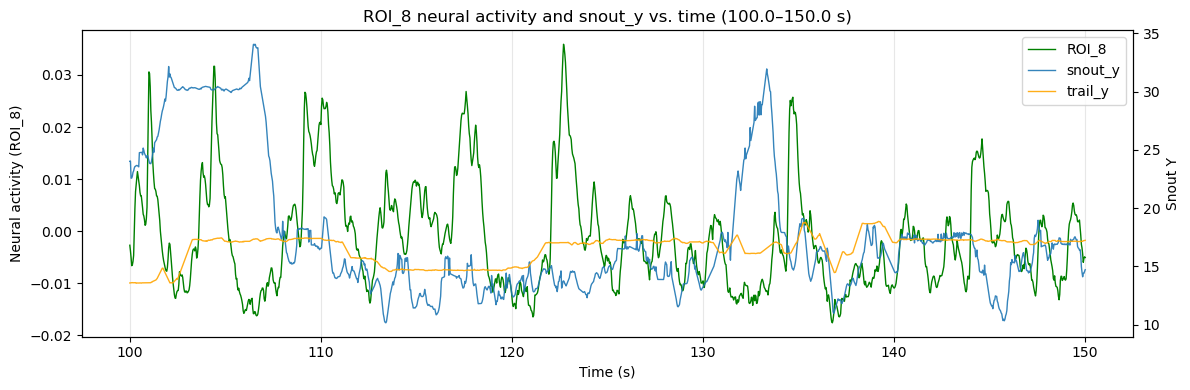

In [13]:
cols = ['ROI_8', 'snout_y', 'trail_y']
df_plot = (merged.loc[:, cols].sort_index().dropna(how='all', subset=cols))

# --- window in SECONDS ---
t_start, t_end = 100.0, 150.0   

# Convert to sample indices (inclusive end)
i_start = int(np.floor(t_start * fs_beh))
i_end   = int(np.floor(t_end   * fs_beh))

# Clip to data bounds
n = len(df_plot)
i_start = max(0, min(i_start, n-1))
i_end   = max(i_start, min(i_end, n-1))

# Slice and build a time axis in seconds for the window
df_win = df_plot.iloc[i_start:i_end+1]
t = np.arange(i_end - i_start + 1) / fs_beh + t_start  # time vector (s)

fig, ax1 = plt.subplots(figsize=(12, 4))
ax2 = ax1.twinx()

ax1.plot(t, df_win['ROI_8'], linewidth=1, label='ROI_8', color='green')
ax2.plot(t, df_win['snout_y'], linewidth=1, alpha=0.9, label='snout_y')
ax2.plot(t, df_win['trail_y'], linewidth=1, alpha=0.9, label='trail_y', color = 'orange')

ax1.set_xlabel('Time (s)')
ax1.set_ylabel('Neural activity (ROI_8)')
ax2.set_ylabel('Snout Y')
ax1.set_title('ROI_8 neural activity and snout_y vs. time ({}–{} s)'.format(t_start, t_end))
ax1.grid(True, axis='x', alpha=0.3)

# Combined legend
h1, l1 = ax1.get_legend_handles_labels()
h2, l2 = ax2.get_legend_handles_labels()
ax1.legend(h1 + h2, l1 + l2, loc='upper right')

plt.tight_layout()
plt.show()


### Behavioral Metrics

##### Trail Following Features

`snout_speed_cm_s`: Scalar speed of the snout (cm/s), from the time-derivative of smoothed snout (x,y).

`heading_rate_deg_s`: Angular velocity of the movement heading (deg/s). Computed from the unwrapped angle of the snout velocity vector; positive ≈ counter-clockwise turn.

`cross_track_cm`: Absolute lateral distance to the trail (cm)

`cross_track_signed_cm`: Signed lateral offset to the trail (cm). Defined with the unit trail tangent t = (tx,ty) and the vector e = (snout − trail):
cross_track_signed = tx*e_y − ty*e_x. Positive = left of the trail’s forward direction.

`along_coord`: Along-trail coordinate. In treadmill mode this is the odometer-like axis (typically trail_x); in general 2-D it is the integrated projection of snout velocity onto the trail tangent.

`cross_track_sm_cm`: Smoothed version of cross_track_cm (Savitzky–Golay) used for robust thresholding.

`d_cross_dt_cm_s`: Time derivative of cross_track_sm_cm (cm/s). Negative values mean the snout is moving toward the trail (approach rate).

`heading_error_deg`: Signed angle between the trail’s forward direction and the movement heading (deg), computed with atan2. 0° = aligned; positive = heading to the left of trail direction; negative = to the right. Range ≈ [−180°, 180°].

`on_trail`: Boolean; True when the animal is considered on the trail based on cross_track_sm_cm with hysteresis/dwell (enter/exit thresholds over a minimum duration).

`following_score`: Continuous score in [0,1] combining distance (closer is better), heading alignment (more aligned is better), and speed (must be moving). Higher = stronger evidence of following.

`corrective`: Boolean; True during “corrective approach” bouts: off-trail, moving, d_cross_dt_cm_s more negative than an adaptive threshold, and a turn occurs near onset; enforced minimum duration.

`approach_slope_thr_cm_s`: Session-level (adaptive) threshold for d_cross_dt_cm_s used to flag approaches (often min(percentile_20_of_neg_slopes, -2 cm/s)).

`on_trail_long_bout_ge2s`: Boolean mask; True for samples that belong to on-trail bouts lasting ≥ 2 s.

`off_trail_long_bout_ge2s`: Boolean mask; True for samples that belong to off-trail bouts lasting ≥ 2 s.

`odor_shift_event`: odor trail turns

In [29]:
def add_trail_metrics(
    df: pd.DataFrame,
    fs: float = fs_beh,
    # smoothing
    smooth_pos_s: float = 0.20,    # Savitzky–Golay window for positions
    smooth_d_s: float = 0.25,      # for distance & its derivative
    # “on-trail” logic
    d_on_cm: float = 2.5,
    d_off_cm: float = 2.5,         # hysteresis (exit threshold)
    tau_on_s: float = 0.3,        # dwell to enter/exit (s)
    tau_off_s: float = 0.3,
    # speed & heading gates (used for “following score” and events)
    v_min_cm_s: float = 1.5,
    # approach detector
    min_approach_cm_s: float = -2.0,  # floor on negative slope of |cross-track|
    head_rate_thr_deg_s: float = 120.0,
    # stationary detector
    v_stat_on_cm_s: float = 4,    # enter stationary at/under this speed
    v_stat_off_cm_s: float = 4.5,   # leave stationary when speed rises above this (hysteresis)
    tau_stat_on_s: float = 0.20,    # dwell to enter stationary
    tau_stat_off_s: float = 0.20,   # dwell to exit stationary
    # odor trail turns 
    # candidate peak finding (on |dθ/dt|)
    theta_rate_abs_min_deg_s: float = 40.0,    # absolute floor for angular speed
    theta_rate_adapt_q: float = 80.0,          # adaptive threshold = q-th percentile of |dθ/dt|
    # acceptance tests around each candidate
    theta_change_min_deg: float = 25.0,        # net heading change across the corner (before vs after)
    theta_rate_prom_min_deg_s: float = 20.0,   # minimal prominence in |dθ/dt|
    window_before_s: float = 0.20,             # window to compute "before" heading
    window_after_s: float  = 0.20,             # window to compute "after" heading
    min_delta_y_cm: float = 1.0,               # minimal |Δy| across the turn
    # refractory spacing and plotting mask
    refrac_s: float = 0.3,                    # minimal spacing between accepted turns
):

    out = df.copy()
    N = len(out)

    t = out.index.to_numpy(dtype=float)

    dt = np.gradient(t)
    dt[dt == 0] = 1/fs

    # raw positions
    Sx, Sy = out["snout_x"].to_numpy(dtype=float), out["snout_y"].to_numpy(dtype=float)
    Tx, Ty = out["trail_x"].to_numpy(dtype=float), out["trail_y"].to_numpy(dtype=float)

    # smoothing 
    def odd(n): return n if n % 2 == 1 else n + 1
    win_pos = max(5, odd(int(round(smooth_pos_s * fs))))
    Sx_s = savgol_filter(Sx, win_pos, 2, mode='interp')
    Sy_s = savgol_filter(Sy, win_pos, 2, mode='interp')
    Tx_s = savgol_filter(Tx, win_pos, 2, mode='interp')
    Ty_s = savgol_filter(Ty, win_pos, 2, mode='interp')

    # speed 
    Vsx = np.gradient(Sx_s, t) 
    Vsy = np.gradient(Sy_s, t)
    speed = np.hypot(Vsx, Vsy)
    out["snout_speed_cm_s"] = speed
    
    # odor trail turns
    dTy  = np.gradient(Ty_s, t) 
    dTx = np.gradient(Tx_s, t) 
    theta = np.unwrap(np.arctan2(dTy, dTx))                 # radians
    theta_deg = np.degrees(theta)
    angspeed = np.abs(np.degrees(np.gradient(theta, t)))    # deg/s
    # --- candidate peaks on |dθ/dt| ---
    # mixed absolute + adaptive threshold
    if np.isfinite(angspeed).any():
        adapt_thr = np.nanpercentile(angspeed[np.isfinite(angspeed)], theta_rate_adapt_q)
    else:
        adapt_thr = 0.0
    thr = max(theta_rate_abs_min_deg_s, float(adapt_thr))
    # use prominence to help separate true corners from jitter
    peaks, props = find_peaks(angspeed, height=thr, prominence=theta_rate_prom_min_deg_s)
    prominences = props.get("prominences", np.array([]))
    # --- evaluate each candidate with stricter local tests ---
    w_before = max(1, int(round(window_before_s * fs)))
    w_after  = max(1, int(round(window_after_s  * fs)))
    accepted = []
    for pk in peaks:
        i0 = max(0, pk - w_before)
        i1 = min(N, pk + w_after + 1)
        if (pk - w_before < 0) or (pk + w_after >= N):
            continue
        # net heading change across the corner (robust: medians)
        theta_pre  = np.nanmedian(theta_deg[pk - w_before: pk])
        theta_post = np.nanmedian(theta_deg[pk + 1: pk + 1 + w_after])
        dtheta = np.abs(((theta_post - theta_pre + 180) % 360) - 180)  # shortest signed diff in degrees
        # lateral excursion in y across a slightly larger window
        dy = np.nanmax(Ty_s[i0:i1]) - np.nanmin(Ty_s[i0:i1])
        # prominence check already enforced by find_peaks; retrieve it
        prom = props["prominences"][np.where(peaks == pk)[0][0]]
        if (dtheta >= theta_change_min_deg) and (dy >= min_delta_y_cm) and (prom >= theta_rate_prom_min_deg_s):
            accepted.append((pk, prom, dtheta, dy))
    # --- enforce refractory: keep strongest (by prominence) within ±refrac_s ---
    accepted = np.array(accepted, dtype=object)  # cols: idx, prom, dtheta, dy
    idxs = accepted[:,0].astype(int)
    proms = accepted[:,1].astype(float)
    refr = max(1, int(round(refrac_s * fs)))
    keep_mask = np.zeros(len(idxs), dtype=bool)
    taken = np.zeros(N, dtype=bool)
    # sort by descending prominence
    order = np.argsort(-proms)
    for j in order:
        k = idxs[j]
        if not taken[max(0, k - refr): min(N, k + refr + 1)].any():
            keep_mask[j] = True
            taken[max(0, k - refr): min(N, k + refr + 1)] = True
    final_idxs = idxs[keep_mask]
    odor_evt = np.zeros(N, dtype=bool)
    odor_evt[final_idxs] = True
    out["odor_shift_event"] = odor_evt
    
    # stationary periods 
    stat_enter = speed <= float(v_stat_on_cm_s)
    stat_exit  = speed <= float(v_stat_off_cm_s)  
    n_on  = max(1, int(round(tau_stat_on_s  * fs)))
    n_off = max(1, int(round(tau_stat_off_s * fs)))
    stationary = np.zeros(N, dtype=bool)
    state = False
    run = 0
    for i in range(N):
        if not state:
            run = run + 1 if stat_enter[i] else 0
            if run >= n_on:
                state = True
                run = 0
        else:
            leave = ~stat_exit[i]   # speed is now high enough to consider exiting
            run = run + 1 if leave else 0
            if run >= n_off:
                state = False
                run = 0
        stationary[i] = state
    out["stationary"] = stationary

    # heading from velocity (robust if ears missing)
    head_ang = np.unwrap(np.arctan2(Vsy, Vsx))
    head_rate_deg_s = np.degrees(np.gradient(head_ang, t))
    out["heading_rate_deg_s"] = head_rate_deg_s

    # cross-track and along-track
    # Along is odometer-like axis (x), cross-track is vertical deviation (y)
    along = Tx_s
    cross_signed = Sy_s - Ty_s

    cross = np.abs(cross_signed)
    out["cross_track_cm"] = cross
    out["cross_track_signed_cm"] = cross_signed
    out["along_coord"] = along

    # distance smoothing & approach rate
    win_d = max(5, odd(int(round(smooth_d_s * fs))))
    cross_sm = savgol_filter(cross, win_d, 2, mode='interp')
    d_cross_dt = savgol_filter(cross, win_d, 2, deriv=1, delta=1/fs, mode='interp')
    out["cross_track_sm_cm"] = cross_sm
    out["d_cross_dt_cm_s"] = d_cross_dt

    # heading vs “trail direction” (treadmill: along x axis)    
    # heading unit vector from velocity
    hx = Vsx / (speed + 1e-9)
    hy = Vsy / (speed + 1e-9)
    # trail tangent in treadmill mode: ±x̂
    tx = np.sign(np.gradient(Tx_s))   # +1 = forward, -1 = backward
    ty = np.zeros_like(tx)
    # signed angle from trail tangent -> heading, in (-180°, 180°]
    dot   = tx*hx + ty*hy            # = trail_dir * hx
    cross = tx*hy - ty*hx            # = trail_dir * hy
    err_deg = np.degrees(np.arctan2(cross, dot))
    # mask when not really moving to avoid noisy angles
    v_min = 1.0  # cm/s, tune
    err_deg = np.where(speed > v_min, err_deg, np.nan)
    out["heading_error_deg"] = err_deg

    # on-trail bouts
    tau_on = max(1, int(round(tau_on_s * fs)))
    tau_off = max(1, int(round(tau_off_s * fs)))
    
    on_raw_enter = cross_sm <= d_on_cm
    on_raw_exit  = cross_sm <= d_off_cm

    following = np.zeros(N, dtype=bool)
    state = False
    run = 0
    for i in range(N):
        if not state:
            run = run + 1 if on_raw_enter[i] else 0
            if run >= tau_on:
                state = True; run = 0
        else:
            # leave only when we exceed d_off for >= tau_off
            leave = ~(on_raw_exit[i])
            run = run + 1 if leave else 0
            if run >= tau_off:
                state = False; run = 0
        following[i] = state
    out["on_trail"] = following

    # on-trail bouts table
    m = following.astype(int)
    edges = np.diff(np.r_[0, m, 0])
    starts_on = np.where(edges == 1)[0]
    ends_on   = np.where(edges == -1)[0]
    segs_on = pd.DataFrame({"start_idx": starts_on, "end_idx": ends_on, "n_frames": ends_on-starts_on})
    segs_on["dur_s"] = segs_on["n_frames"] / fs
    if "t_s" in out.columns:
        segs_on["t_start_s"] = out["t_s"].values[starts_on]
        segs_on["t_end_s"]   = out["t_s"].values[ends_on-1]
        
    # mark samples that belong to on-trail bouts lasting ≥ 2 s
    min_bout_s = 2.0
    min_len = int(np.ceil(min_bout_s * fs)) 
    
    is_long_on = (segs_on["dur_s"].to_numpy() >= min_bout_s)
    long_bout_on_mask = np.zeros(len(out), dtype=bool)
    for s, e, keep in zip(starts_on, ends_on, is_long_on):    # note: [s, e) with e exclusive
        if keep:
            long_bout_on_mask[s:e] = True
    out["on_trail_long_bout_ge2s"] = long_bout_on_mask  # True = part of a ≥2 s on-trail bout
    
    # off-trail bouts 
    off_raw_enter = cross_sm >= 5
    off_raw_exit  = cross_sm >= 5
    
    leaving = np.zeros(N, dtype=bool)
    state = False
    run = 0
    for i in range(N):
        if not state:
            run = run + 1 if off_raw_enter[i] else 0
            if run >= tau_on:
                state = True; run = 0
        else:
            # leave only when we exceed d_off for >= tau_off
            leave = ~(off_raw_exit[i])
            run = run + 1 if leave else 0
            if run >= tau_off:
                state = False; run = 0
        leaving[i] = state
    out["off_trail"] = leaving
    # off-trail bouts tables
    l = (leaving).astype(int)
    edges = np.diff(np.r_[0, l, 0])
    starts_off = np.where(edges == 1)[0]
    ends_off = np.where(edges == -1)[0]
    segs_off = pd.DataFrame({"start_idx": starts_off, "end_idx": ends_off, "n_frames": ends_off-starts_off})
    segs_off["dur_s"] = segs_off["n_frames"] / fs
    if "t_s" in out.columns:
        segs_off["t_start_s"] = out["t_s"].values[starts_off]
        segs_off["t_end_s"]   = out["t_s"].values[ends_off-1]
    # mark samples that belong to off-trail bouts lasting ≥ 2 s
    min_bout_s = 2.0
    min_len = int(np.ceil(min_bout_s * fs)) 
    is_long = (segs_off["dur_s"].to_numpy() >= min_bout_s)
    long_bout_off_mask = np.zeros(len(out), dtype=bool)
    for s, e, keep in zip(starts_off, ends_off, is_long):    # note: [s, e) with e exclusive
        if keep:
            long_bout_off_mask[s:e] = True
    out["off_trail_long_bout_ge2s"] = long_bout_off_mask  # True = part of a ≥2 s off-trail bout

    # continuous following score (no hard threshold)
    # distance term: Gaussian in cross-track
    d0 = max(1.0, d_on_cm)   # scale of “good” distance
    dist_score = np.exp(-(cross_sm / d0)**2)
    # heading term: prefer aligned; clamp negative cosines to 0
    head_good = np.clip(np.cos(np.radians(out["heading_error_deg"].to_numpy())), 0, 1)
    # speed term: logistic around v_min
    v = speed
    k = 2.0 / max(1.0, v_min_cm_s)   # steepness
    speed_score = 1.0 / (1.0 + np.exp(-k*(v - v_min_cm_s)))
    follow_score = dist_score * head_good #* speed_score
    out["following_score"] = follow_score

    # corrective approach
    # “approach” means |cross-track| is decreasing fast AND the animal turns near onset.
    neg = d_cross_dt[d_cross_dt < 0]
    adapt_thr = np.nanpercentile(neg, 20) if neg.size else -np.inf
    approach_thr = min(adapt_thr, min_approach_cm_s)
    approaching_fast = d_cross_dt <= approach_thr
    turning_fast = np.abs(head_rate_deg_s) >= head_rate_thr_deg_s
    # demand a turn within ±0.3 s of approach
    W = max(1, int(round(0.30 * fs)))
    turn_near = np.convolve(turning_fast.astype(int), np.ones(2*W+1, int), mode='same') > 0
    moving = v >= v_min_cm_s
    off_trail = cross_sm > d_off_cm
    corrective = approaching_fast & turn_near & moving & off_trail
    # keep only sustained ≥ 0.2 s
    min_len = max(1, int(round(0.20 * fs)))
    mask = np.zeros(N, dtype=bool)
    mm = corrective.astype(int)
    ed = np.diff(np.r_[0, mm, 0])
    ss = np.where(ed == 1)[0]; ee = np.where(ed == -1)[0]
    for s, e in zip(ss, ee):
        if (e - s) >= min_len:
            mask[s:e] = True
    out["corrective"] = mask
    out["approach_slope_thr_cm_s"] = approach_thr  # for debugging

    return out


In [30]:
merged = add_trail_metrics(merged)
print(merged.columns)
print(merged.head())


Index(['ROI_8', 'ROI_9', 'ROI_14', 'snout_x', 'snout_y', 'rightear_x',
       'rightear_y', 'leftear_x', 'leftear_y', 'tailbase_x', 'tailbase_y',
       'trail_x', 'trail_y', 'snout_speed_cm_s', 'odor_shift_event',
       'stationary', 'heading_rate_deg_s', 'cross_track_cm',
       'cross_track_signed_cm', 'along_coord', 'cross_track_sm_cm',
       'd_cross_dt_cm_s', 'heading_error_deg', 'on_trail',
       'on_trail_long_bout_ge2s', 'off_trail', 'off_trail_long_bout_ge2s',
       'following_score', 'corrective', 'approach_slope_thr_cm_s'],
      dtype='object')
             ROI_8     ROI_9    ROI_14      snout_x    snout_y   rightear_x  \
time_s                                                                        
0.000000  0.042336  0.037198  0.001847  2411.383475  29.435197  2410.864509   
0.033333  0.039411  0.036226  0.001766  2412.773541  29.435197  2413.055577   
0.066667  0.036497  0.034436  0.001760  2412.821020  29.435197  2410.442241   
0.100000  0.033595  0.031828  0.00182

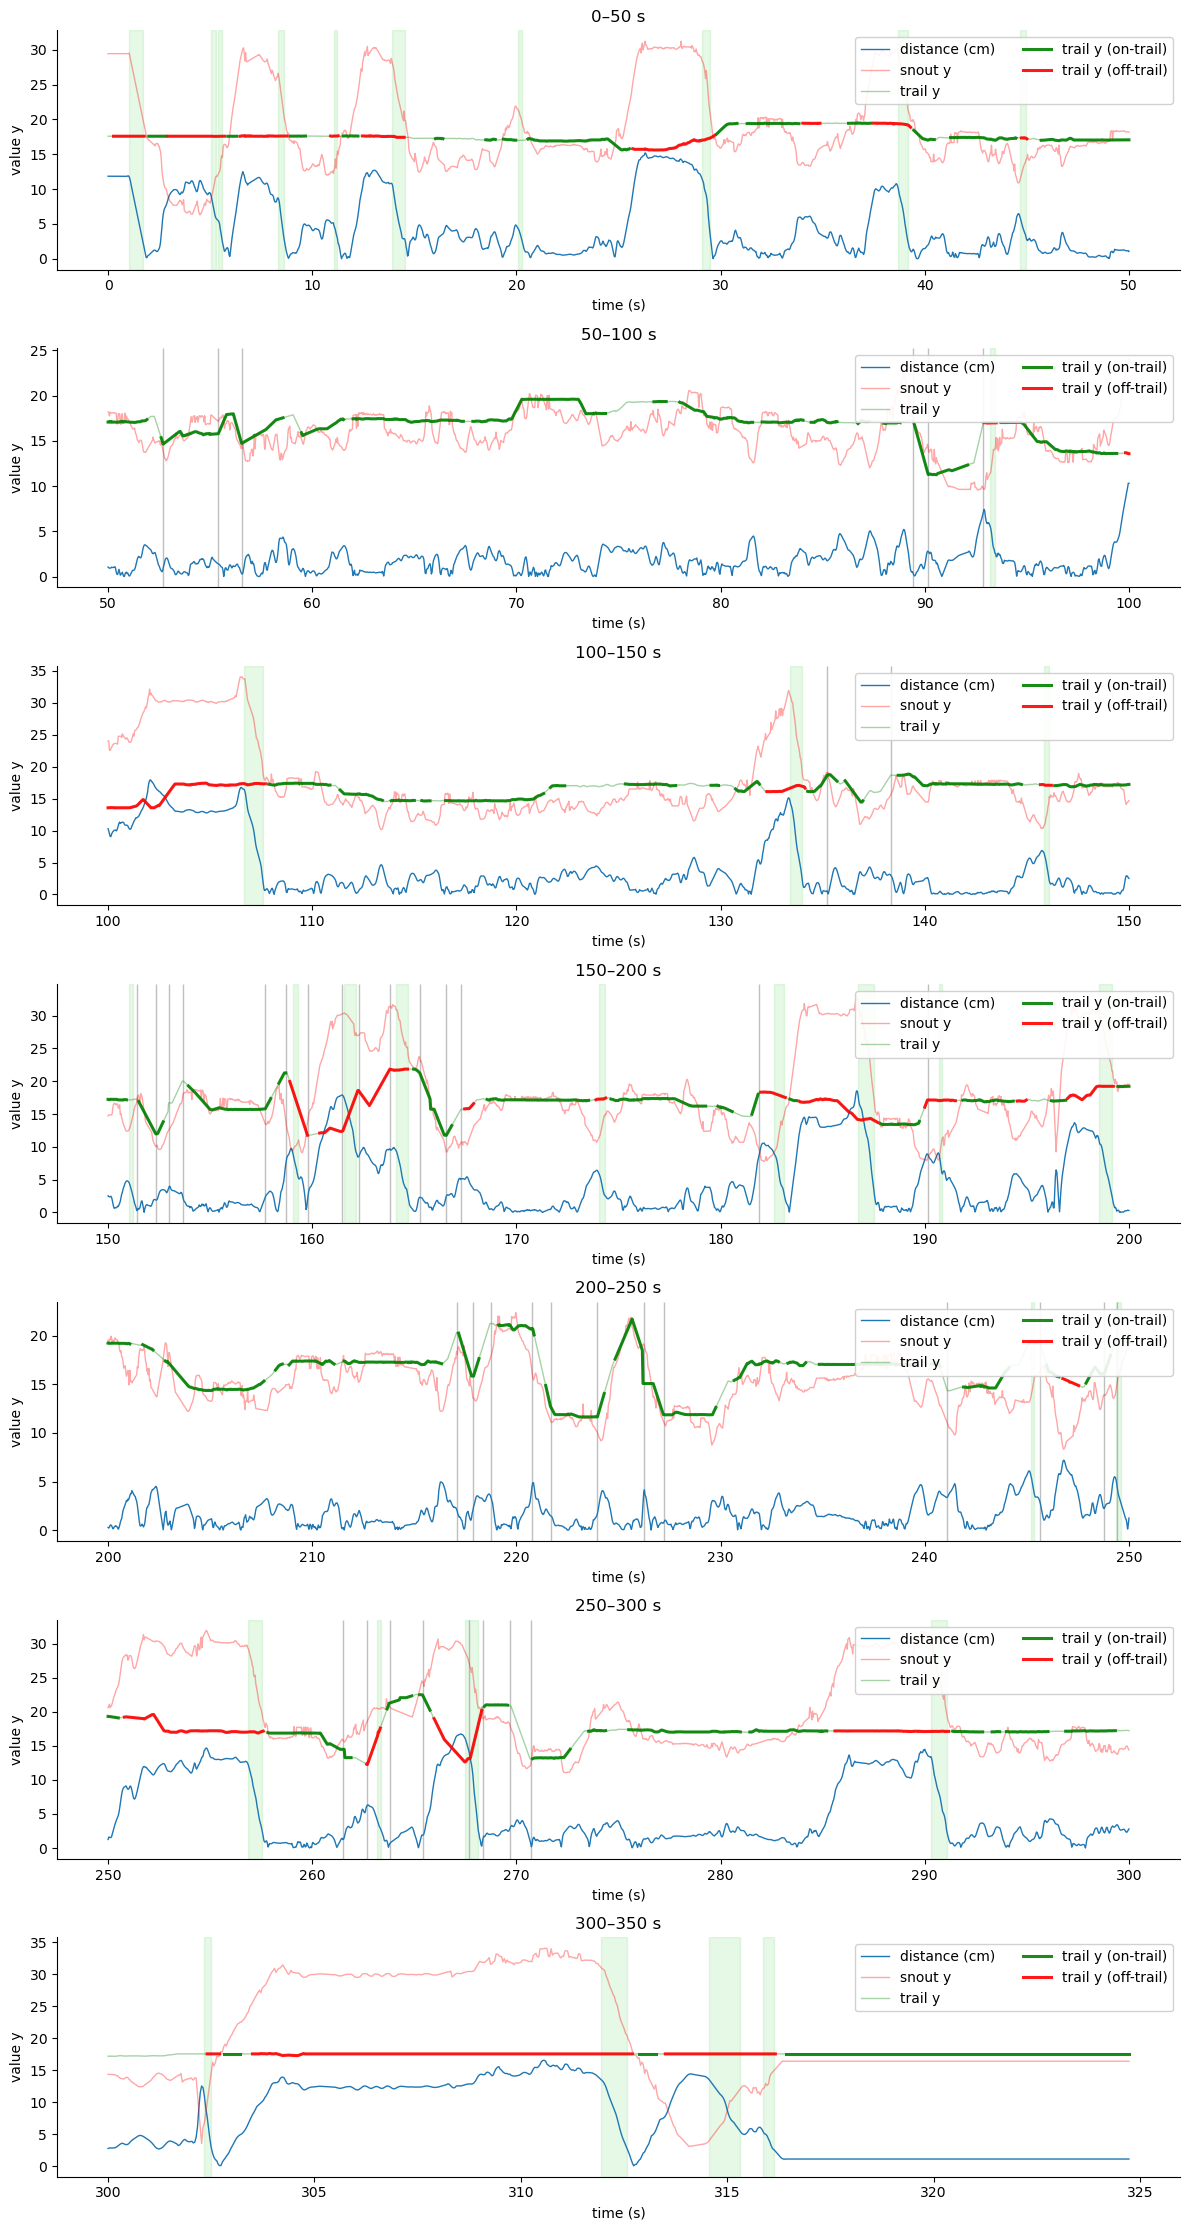

In [31]:
def plot_time_windows(df2, windows):
    fig, axs = plt.subplots(len(windows), 1, figsize=(12, 3.2*len(windows)), sharex=False)
    if len(windows) == 1:
        axs = [axs]

    for ax, (t0, t1) in zip(axs, windows):
        seg = df2.loc[t0:t1] if df2.index.is_monotonic_increasing else df2[(df2['t_s']>=t0)&(df2['t_s']<t1)]
        tt = seg.index.to_numpy()

        # --- base signals (y-axis) ---
        ax.plot(tt, seg['cross_track_cm'], lw=1, label='distance (cm)')
        ax.plot(tt, seg['snout_y'],  alpha=0.35, lw=1, color="red",   label='snout y')
        ax.plot(tt, seg['trail_y'],  alpha=0.35, lw=1, color="green", label='trail y')

        # --- shade corrective (green translucent) ---
        m_corr = seg['corrective'].to_numpy()
        edges = np.diff(np.r_[0, m_corr.astype(int), 0])
        s_idx = np.where(edges == 1)[0]; e_idx = np.where(edges == -1)[0]
        for s, e in zip(s_idx, e_idx):
            ax.axvspan(tt[s], tt[e-1], color='limegreen', alpha=0.12, zorder=0)
            
        # --- shade trail turns ---
        m_corr = seg['odor_shift_event'].to_numpy()
        edges = np.diff(np.r_[0, m_corr.astype(int), 0])
        s_idx = np.where(edges == 1)[0]; e_idx = np.where(edges == -1)[0]
        for s, e in zip(s_idx, e_idx):
            ax.axvspan(tt[s], tt[e-1], color='grey', alpha=0.5, zorder=0)

        m_on = seg['on_trail'].to_numpy().astype(bool)
        m_off = seg['off_trail'].to_numpy().astype(bool)

        def masked(arr, mask):
            a = arr.astype(float).copy()
            a[~mask] = np.nan
            return a
        ax.plot(tt, masked(seg['trail_y'].to_numpy(), m_on),
                color='green', lw=2.2, alpha=0.9, label='trail y (on-trail)')
        ax.plot(tt, masked(seg['trail_y'].to_numpy(), m_off),
                color='red', lw=2.2, alpha=0.9, label='trail y (off-trail)')

        # labels/titles
        ax.set_title(f'{t0}–{t1} s')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('value y')

        # combine legends from both axes
        h1, l1 = ax.get_legend_handles_labels()
        ax.legend(h1, l1, loc='upper right', ncol=2, framealpha=0.9)

    plt.tight_layout()


plot_time_windows(merged, [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350)])


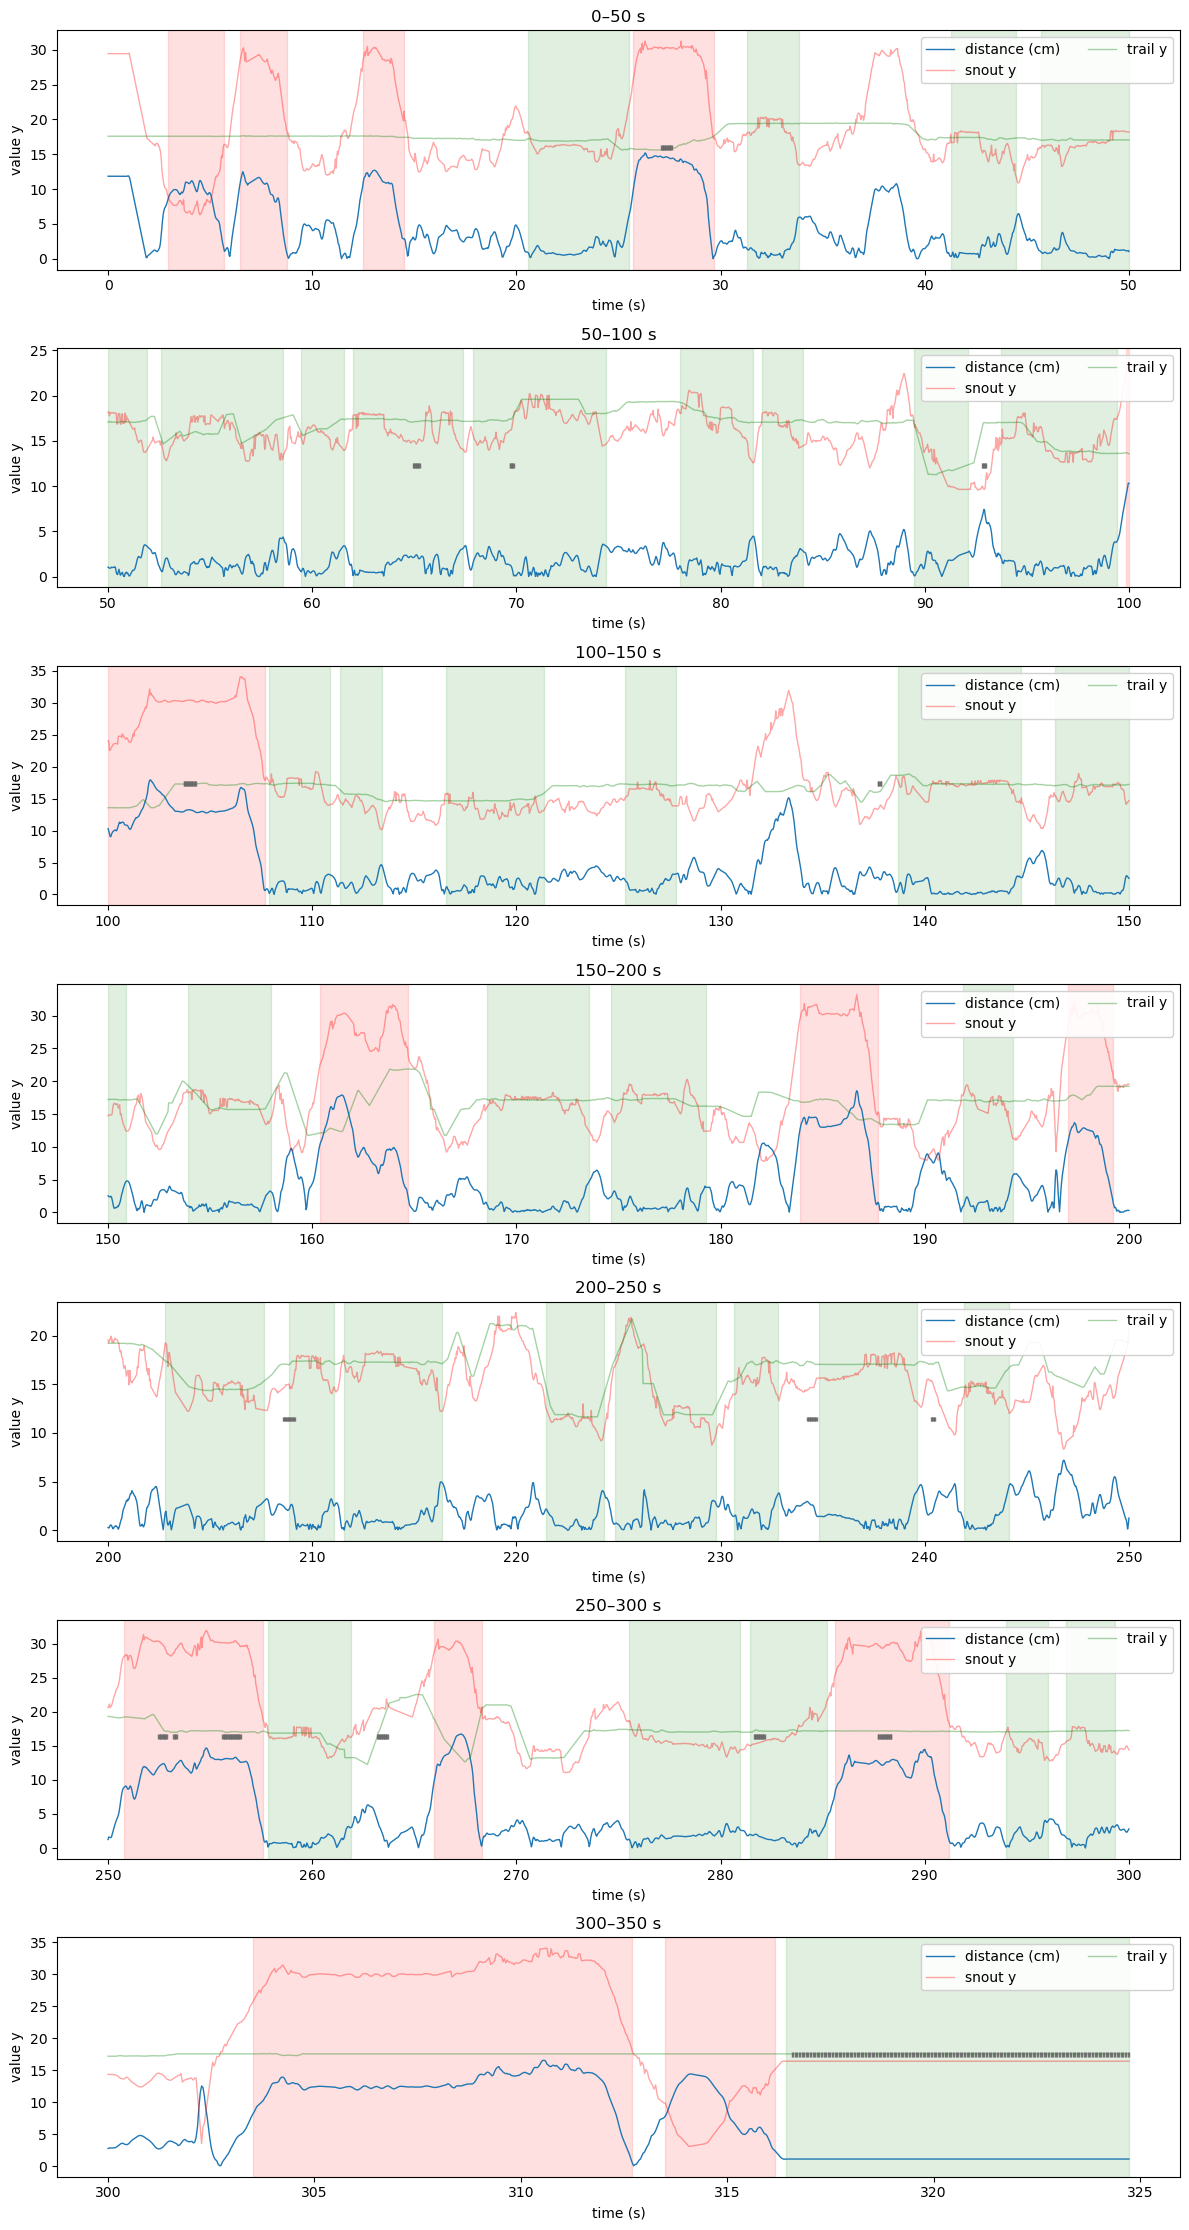

In [17]:
def plot_windows_classification(df2, windows):
    fig, axs = plt.subplots(len(windows), 1, figsize=(12, 3.2*len(windows)), sharex=False)
    if len(windows) == 1:
        axs = [axs]

    for ax, (t0, t1) in zip(axs, windows):
        seg = df2.loc[t0:t1] if df2.index.is_monotonic_increasing else df2[(df2['t_s']>=t0)&(df2['t_s']<t1)]
        tt = seg.index.to_numpy()

        # --- base signals (y-axis) ---
        ax.plot(tt, seg['cross_track_cm'], lw=1, label='distance (cm)')
        ax.plot(tt, seg['snout_y'],  alpha=0.35, lw=1, color="red",   label='snout y')
        ax.plot(tt, seg['trail_y'],  alpha=0.35, lw=1, color="green", label='trail y')

        # --- shade long following bouts ---
        m_corr = seg['on_trail_long_bout_ge2s'].to_numpy()
        edges = np.diff(np.r_[0, m_corr.astype(int), 0])
        s_idx = np.where(edges == 1)[0]; e_idx = np.where(edges == -1)[0]
        for s, e in zip(s_idx, e_idx):
            ax.axvspan(tt[s], tt[e-1], color='green', alpha=0.12, zorder=0)
            
        # --- shade long not following bouts ---
        m_corr = seg['off_trail_long_bout_ge2s'].to_numpy()
        edges = np.diff(np.r_[0, m_corr.astype(int), 0])
        s_idx = np.where(edges == 1)[0]; e_idx = np.where(edges == -1)[0]
        for s, e in zip(s_idx, e_idx):
            ax.axvspan(tt[s], tt[e-1], color='red', alpha=0.12, zorder=0)
            
        # --- FLAG stationary bouts with a top rug (no shading) ---
        mask_stat = seg['stationary'].fillna(False).astype(bool).to_numpy()
        y0, y1 = 0.5, 0.52
        ax.vlines(tt[mask_stat], ymin=y0, ymax=y1, transform=ax.get_xaxis_transform(),
                  color='dimgray', lw=1, alpha=0.9, zorder=10)


        # labels/titles
        ax.set_title(f'{t0}–{t1} s')
        ax.set_xlabel('time (s)')
        ax.set_ylabel('value y')

        # combine legends from both axes
        h1, l1 = ax.get_legend_handles_labels()
        ax.legend(h1, l1, loc='upper right', ncol=2, framealpha=0.9)

    plt.tight_layout()

# Example
plot_windows_classification(merged, [(0, 50), (50, 100), (100, 150), (150, 200), (200, 250), (250, 300), (300, 350)])


Sampling: dt=0.0333 s, duration=5.41 min


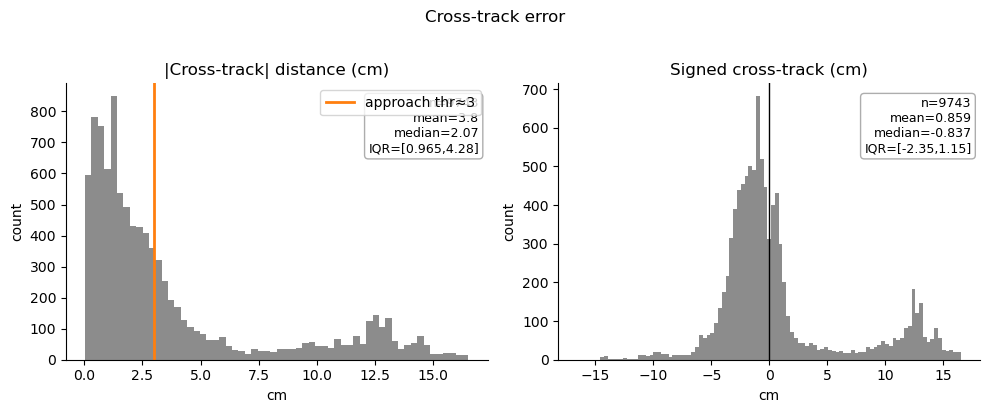

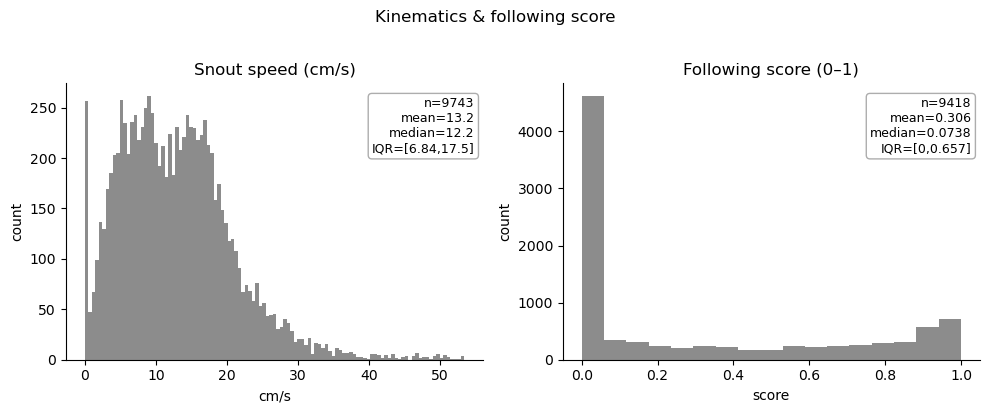

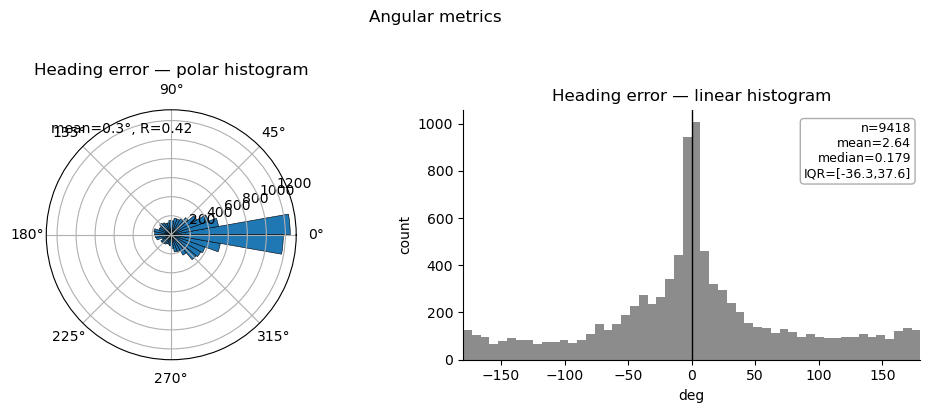

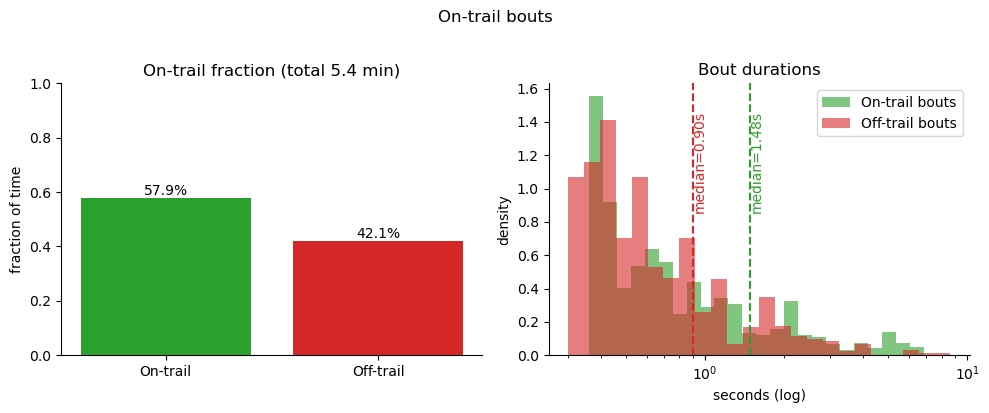

In [18]:
plt.rcParams.update({
    "figure.figsize": (8, 5),
    "axes.spines.top": False,
    "axes.spines.right": False,
})

# %% Helpers
def freedman_diaconis_bins(x):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size < 2:
        return 10
    iqr = np.subtract(*np.nanpercentile(x, [75, 25]))
    if iqr == 0:
        return min(50, max(5, int(np.sqrt(x.size))))
    h = 2 * iqr * (x.size ** (-1/3))
    if h == 0:
        return min(50, max(5, int(np.sqrt(x.size))))
    return int(np.clip(np.ceil((np.nanmax(x) - np.nanmin(x)) / h), 10, 200))

def robust_xlim(x, q=0.995, symmetric=False):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0:
        return None
    lo, hi = np.nanpercentile(x, [(1-q)*100, q*100])
    if symmetric:
        m = max(abs(lo), abs(hi))
        return (-m, m)
    return (lo, hi)

def ecdf(y):
    y = np.asarray(y)
    y = y[np.isfinite(y)]
    if y.size == 0:
        return np.array([]), np.array([])
    y_sorted = np.sort(y)
    p = np.arange(1, y_sorted.size+1) / y_sorted.size
    return y_sorted, p

def polar_hist(ax, angles, bins=36):
    # angles in radians
    a = np.asarray(angles)
    a = a[np.isfinite(a)]
    if a.size == 0:
        return
    # wrap to [0, 2π)
    a = (a + 2*np.pi) % (2*np.pi)
    counts, edges = np.histogram(a, bins=bins, range=(0, 2*np.pi))
    widths = np.diff(edges)
    ax.bar(edges[:-1], counts, width=widths, align='edge', edgecolor='k', linewidth=0.4)
    # mean resultant vector
    z = np.exp(1j * a).mean() if a.size else 0
    mu = np.angle(z)
    R = np.abs(z)
    ax.annotate(f"mean={np.degrees(mu):.1f}°, R={R:.2f}", xy=(0.02, 0.95),
                xycoords='axes fraction', ha='left', va='top')

def bout_lengths(bool_series, dt):
    # returns durations (s) of consecutive True runs and False runs
    b = np.asarray(bool_series, dtype=bool)
    if b.size == 0:
        return np.array([]), np.array([])
    # run-length encode
    changes = np.diff(b.astype(int), prepend=b[0])
    idx = np.flatnonzero(changes != 0)
    # prepend start if first run starts at 0
    starts = np.r_[0, idx]
    ends = np.r_[idx, b.size-1]  # inclusive end indices of runs
    vals = b[starts]
    lengths = (ends - starts + 1) * dt
    on_durs = lengths[vals]
    off_durs = lengths[~vals]
    return on_durs, off_durs

def event_rate_and_iei(event_series, dt):
    e = np.asarray(event_series, dtype=bool)
    times = np.arange(e.size) * dt
    n = int(e.sum())
    duration = e.size * dt
    rate_per_min = (n / duration) * 60.0 if duration > 0 else np.nan
    # IEIs: times between event True indices
    t_events = times[e]
    iei = np.diff(t_events) if t_events.size >= 2 else np.array([])
    return rate_per_min, iei

def annotate_stats(ax, x, where='right'):
    x = np.asarray(x)
    x = x[np.isfinite(x)]
    if x.size == 0: 
        return
    msg = (f"n={x.size}\n"
           f"mean={np.nanmean(x):.3g}\n"
           f"median={np.nanmedian(x):.3g}\n"
           f"IQR=[{np.nanpercentile(x,25):.3g},{np.nanpercentile(x,75):.3g}]")
    if where == 'right':
        ax.annotate(msg, xy=(0.98, 0.95), xycoords='axes fraction',
                    ha='right', va='top', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.6', alpha=0.8))
    else:
        ax.annotate(msg, xy=(0.02, 0.95), xycoords='axes fraction',
                    ha='left', va='top', fontsize=9,
                    bbox=dict(boxstyle='round,pad=0.3', fc='white', ec='0.6', alpha=0.8))

def plot_behavior_metric_distributions(df: pd.DataFrame):
    """
    Plot distribution panels (hist/ECDF/bout stats) for the available metrics.
    Assumes the index is time in seconds (float or Int -> seconds).
    Returns a dict of figures.
    """
    # ---- time base ----
    t = df.index.to_numpy().astype(float)
    if t.size < 2:
        raise ValueError("DataFrame index must be time in seconds with >= 2 samples.")
    dt = float(np.median(np.diff(t)))
    duration_min = (t[-1] - t[0]) / 60.0

    # ------------------- FIG 1: Cross-track error -------------------
    fig1, axes = plt.subplots(1, 2, figsize=(10, 4))

    # |cross-track| histogram (unsmoothed)
    ax = axes[0]
    x = df["cross_track_cm"].to_numpy()
    bins = freedman_diaconis_bins(x)
    rng = robust_xlim(x, q=0.995)
    ax.hist(x[np.isfinite(x)], bins=bins, range=rng, color='0.55')
    thr = 3
    ax.axvline(thr, color='C1', lw=2, label=f"approach thr≈{thr}")
    ax.legend()
    ax.set_title("|Cross-track| distance (cm)")
    ax.set_xlabel("cm"); ax.set_ylabel("count")
    annotate_stats(ax, x)

    # signed cross-track histogram (symmetric)
    ax = axes[1]
    xs = df["cross_track_signed_cm"].to_numpy()
    bins = freedman_diaconis_bins(xs)
    rng = robust_xlim(xs, q=0.995, symmetric=True)
    ax.hist(xs[np.isfinite(xs)], bins=bins, range=rng, color='0.55')
    ax.axvline(0, color='k', lw=1)
    ax.set_title("Signed cross-track (cm)")
    ax.set_xlabel("cm"); ax.set_ylabel("count")
    annotate_stats(ax, xs)

    fig1.suptitle("Cross-track error", y=1.02)
    fig1.tight_layout()

    # ------------------- FIG 2: Kinematics & following score -------------------
    fig2, axes = plt.subplots(1, 2, figsize=(10, 4))

    # snout speed
    ax = axes[0]
    spd = df["snout_speed_cm_s"].to_numpy()
    bins = freedman_diaconis_bins(spd)
    rng = robust_xlim(spd, q=0.995)
    ax.hist(spd[np.isfinite(spd)], bins=bins, range=rng, color='0.55')
    ax.set_title("Snout speed (cm/s)")
    ax.set_xlabel("cm/s"); ax.set_ylabel("count")
    annotate_stats(ax, spd)


    # following score (0..1)
    ax = axes[1]
    fs = df["following_score"].to_numpy()
    bins = min(40, max(10, freedman_diaconis_bins(fs)))
    rng = (0, 1)
    ax.hist(fs[np.isfinite(fs)], bins=bins, range=rng, color='0.55')
    ax.set_title("Following score (0–1)")
    ax.set_xlabel("score"); ax.set_ylabel("count")
    annotate_stats(ax, fs)

    fig2.suptitle("Kinematics & following score", y=1.02)
    fig2.tight_layout()

    # ------------------- FIG 3: Angular metrics (heading relative to trail) -------------------
    fig3 = plt.figure(figsize=(10, 4))
    gs = fig3.add_gridspec(1, 2, width_ratios=[1, 1.2])

    # Polar histogram needs radians
    ax_polar = fig3.add_subplot(gs[0, 0], projection='polar')
    if "heading_error_deg" in df.columns:
        ang_rad = np.radians(df["heading_error_deg"].to_numpy())
        polar_hist(ax_polar, ang_rad, bins=36)
    ax_polar.set_title("Heading error — polar histogram")

    ax_lin = fig3.add_subplot(gs[0, 1])
    if "heading_error_deg" in df.columns:
        a_deg = df["heading_error_deg"].to_numpy()
        bins = freedman_diaconis_bins(a_deg)
        ax_lin.hist(a_deg[np.isfinite(a_deg)], bins=bins, range=(-180, 180), color='0.55')
        ax_lin.set_xlim(-180, 180)
        ax_lin.axvline(0, color='k', lw=1)
        annotate_stats(ax_lin, a_deg)
    ax_lin.set_title("Heading error — linear histogram")
    ax_lin.set_xlabel("deg"); ax_lin.set_ylabel("count")

    fig3.suptitle("Angular metrics", y=1.02)
    fig3.tight_layout()

    # ------------------- FIG 4: On-trail bouts & corrective events -------------------
    
    # ------- On-trail bouts & corrective events (robust) -------

    fig4, axes = plt.subplots(1, 2, figsize=(10, 4))

    # (A) Share of time on-trail
    ax = axes[0]
    on = df["on_trail"].to_numpy(bool)
    frac_on = np.nanmean(on.astype(float))
    ax.bar(["On-trail", "Off-trail"], [frac_on, 1-frac_on], color=['C2','C3'])
    ax.set_ylim(0,1); ax.set_ylabel("fraction of time")
    ax.set_title(f"On-trail fraction (total {(t[-1]-t[0])/60:.1f} min)")
    ax.text(0, frac_on, f"{100*frac_on:.1f}%", ha='center', va='bottom')
    ax.text(1, 1-frac_on, f"{100*(1-frac_on):.1f}%", ha='center', va='bottom')

    # (B) Bout durations (log x, density, medians)
    def runs_to_durations(b, dt):
        b = np.asarray(b, dtype=bool)
        if b.size == 0:
            return np.array([]), np.array([])
        # change points between consecutive samples
        change = np.flatnonzero(np.diff(b.astype(int)))
        # start/end of every run (include first and last)
        starts = np.r_[0, change + 1]
        ends   = np.r_[change + 1, b.size]
        vals   = b[starts]                 # value of each run (True/False)
        lens   = (ends - starts) * dt      # duration (s) of each run
        on_durs  = lens[vals]
        off_durs = lens[~vals]
        return on_durs, off_durs

    ax = axes[1]
    on_durs, off_durs = runs_to_durations(on, dt)

    def log_hist(ax, data, label, color):
        if data.size == 0: return
        lo, hi = np.nanpercentile(data, [1, 99])
        lo = max(lo, 1e-2)
        edges = np.logspace(np.log10(lo), np.log10(hi), 25)
        ax.hist(data, bins=edges, density=True, alpha=0.6, label=label, color=color)
        med = np.nanmedian(data)
        ax.axvline(med, color=color, ls='--', lw=1.5)
        ax.text(med, ax.get_ylim()[1]*0.9, f"median={med:.2f}s", color=color, rotation=90, va='top')

    log_hist(ax, on_durs,  "On-trail bouts",  'C2')
    log_hist(ax, off_durs, "Off-trail bouts",'C3')
    ax.set_xscale('log'); ax.set_xlabel("seconds (log)"); ax.set_ylabel("density")
    ax.set_title("Bout durations")
    ax.legend()


    fig4.suptitle("On-trail bouts", y=1.02)
    fig4.tight_layout()


    print(f"Sampling: dt={dt:.4f} s, duration={duration_min:.2f} min")

plot_behavior_metric_distributions(merged)

##### Photometry Features

### Analysis

#### Compare long on-trail VS off-trail bouts

##### Avg neural activity per bout

In [19]:
def run_spans(mask: np.ndarray):

    m = np.asarray(mask, dtype=bool)
    if m.size == 0:
        return np.array([], dtype=int), np.array([], dtype=int)
    edges = np.diff(np.r_[False, m, False].astype(int))
    starts = np.flatnonzero(edges == 1)
    ends_excl = np.flatnonzero(edges == -1)        # end is exclusive
    return starts, ends_excl

# Compute spans for long on-trail and off-trail bouts
on_starts,  on_ends  = run_spans(merged['on_trail_long_bout_ge2s'].to_numpy())
off_starts, off_ends = run_spans(merged['off_trail_long_bout_ge2s'].to_numpy())

In [20]:
print(off_starts)
print(off_ends)

[  88  194  374  771 2995 4811 5516 5910 7524 7979 8568 9105 9405]
[ 172  264  436  892 3232 4941 5632 5978 7729 8050 8736 9382 9486]


In [21]:
print(on_starts)
print(on_ends)

[ 617  939 1238 1371 1578 1784 1860 2036 2340 2461 2684 2812 3236 3341
 3496 3760 4161 4391 4618 5057 5239 5756 6084 6266 6347 6643 6745 6920
 7045 7257 7735 8265 8443 8820 8907 9493]
[ 767 1016 1335 1558 1758 1847 2023 2232 2448 2522 2764 2983 3327 3404
 3641 3835 4343 4528 4740 5207 5379 5831 6230 6333 6491 6730 6894 6986
 7189 7325 7858 8430 8557 8882 8981 9743]


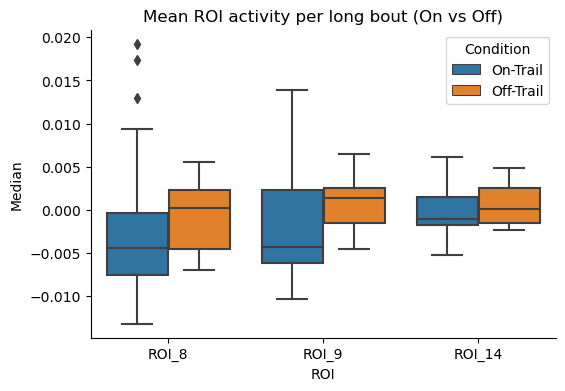

In [22]:
# Calculate mean activity per bout for each ROI
on_means = {roi: [] for roi in ['ROI_8','ROI_9','ROI_14']}
off_means = {roi: [] for roi in ['ROI_8','ROI_9','ROI_14']}

for s,e in zip(on_starts, on_ends):
    for roi in on_means:
        on_means[roi].append( np.median(merged.iloc[s+2:e+2][roi].values) )
for s,e in zip(off_starts, off_ends):
    for roi in off_means:
        off_means[roi].append( np.median(merged.iloc[s+2:e+2][roi].values) )
        

bout_mean_records = []
for roi in ['ROI_8','ROI_9','ROI_14']:
    bout_mean_records += [{'ROI': roi, 'Condition': 'On-Trail', 'Median': val} for val in on_means[roi]]
    bout_mean_records += [{'ROI': roi, 'Condition': 'Off-Trail','Median': val} for val in off_means[roi]]
bout_mean_df = pd.DataFrame(bout_mean_records)

plt.figure(figsize=(6,4))
sns.boxplot(x="ROI", y="Median", hue="Condition", data=bout_mean_df)
plt.title("Mean ROI activity per long bout (On vs Off)")
plt.show()


##### Peak Frequency and Shape

Peak-rate summary (concatenated bouts):
   ROI Condition  n_peaks  duration_s  rate_per_min  rate_lo   rate_hi  mean_amp  median_amp  mean_width_s  median_width_s
 ROI_8  On-Trail       20  140.933333      8.514664 4.782948 12.246380  0.030926    0.027427      0.898560        0.764683
 ROI_8 Off-Trail        6   54.600000      6.593407 1.317583 11.869231  0.029805    0.027616      0.501395        0.413657
 ROI_9  On-Trail       14  140.933333      5.960265 2.838087  9.082443  0.020061    0.018007      0.937349        0.807301
 ROI_9 Off-Trail        3   54.600000      3.296703 0.000000  7.027274  0.027249    0.020113      1.019897        1.174142
ROI_14  On-Trail       19  140.933333      8.088931 4.451704 11.726158  0.009100    0.008889      0.931855        0.458194
ROI_14 Off-Trail        9   54.600000      9.890110 3.428571 16.351648  0.009405    0.008816      1.009431        0.645763


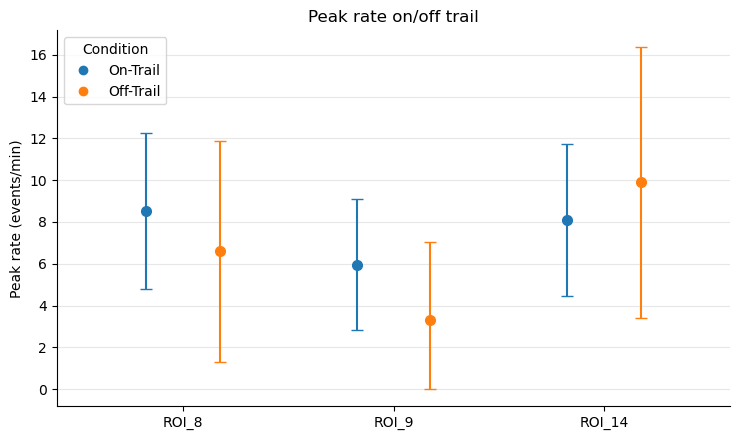

In [23]:
def concat_segments(x, starts, ends, pad_samples=2):
    """
    Concatenate segments x[s:e] across all (start,end) with a small edge guard (pad).
    Returns concatenated vector and total number of samples accumulated.
    """
    segs = []
    total = 0
    for s, e in zip(starts, ends):
        s2 = s + pad_samples
        e2 = e - pad_samples
        if e2 <= s2:  # skip tiny bouts
            continue
        seg = x[s2:e2]
        if seg.size == 0 or not np.isfinite(seg).all():
            continue
        segs.append(seg)
        total += seg.size
    if len(segs) == 0:
        return np.array([]), 0
    return np.concatenate(segs), total

def poisson_rate_ci_95(n_events, duration_s):
    """
    Approx 95% CI for event rate per MIN via normal approx on counts.
    rate_per_min = n / T * 60;  stderr = sqrt(n)/T * 60
    """
    if duration_s <= 0:
        return np.nan, np.nan, np.nan
    rate_per_min = (n_events / duration_s) * 60.0
    if n_events == 0:
        # conservative: CI goes from 0 to ~ 1.96/sqrt(T) * 60
        err = (1.96 * 1.0 / np.sqrt(max(1e-9, duration_s))) * 60.0
    else:
        err = (1.96 * np.sqrt(n_events) / duration_s) * 60.0
    lo = max(0.0, rate_per_min - err)
    hi = rate_per_min + err
    return rate_per_min, lo, hi

rois = ['ROI_8','ROI_9','ROI_14']
rows = []
peak_details = []  # optional: store individual detected peak features if you want to plot distributions

for roi in rois:
    x = merged[roi].to_numpy()

    for cond, s_arr, e_arr in [('On-Trail', on_starts, on_ends),
                               ('Off-Trail', off_starts, off_ends)]:
        # 1) concatenate all long-bout segments
        concat_sig, n_samp = concat_segments(x, s_arr, e_arr, pad_samples=2)
        dur_s = n_samp / float(fs_beh) if n_samp > 0 else 0.0

        if n_samp == 0:
            rows.append(dict(ROI=roi, Condition=cond,
                             n_peaks=0, duration_s=0.0,
                             rate_per_min=np.nan, rate_lo=np.nan, rate_hi=np.nan,
                             mean_amp=np.nan, median_amp=np.nan,
                             mean_width_s=np.nan, median_width_s=np.nan))
            continue

        # 2) detect peaks on the concatenated signal
        thr = np.nanmean(concat_sig) + 2.0 * np.nanstd(concat_sig)   # your threshold rule
        min_dist = int(round(0.5 * fs_beh))  # at least 0.5 s apart
        peaks, props = find_peaks(concat_sig, height=thr, distance=min_dist)
        heights = props.get('peak_heights', np.array([]))

        if peaks.size > 0:
            widths_samp = peak_widths(concat_sig, peaks, rel_height=0.5)[0]
            widths_s = widths_samp / float(fs_beh)
            mean_amp = float(np.nanmean(heights))
            median_amp = float(np.nanmedian(heights))
            mean_w = float(np.nanmean(widths_s))
            median_w = float(np.nanmedian(widths_s))
            for h, w in zip(heights, widths_s):
                peak_details.append(dict(ROI=roi, Condition=cond, amp=h, width_s=w))
        else:
            mean_amp = median_amp = mean_w = median_w = np.nan

        # 3) compute rate and 95% CI
        n_peaks = int(peaks.size)
        rate_per_min, lo, hi = poisson_rate_ci_95(n_peaks, dur_s)

        rows.append(dict(ROI=roi, Condition=cond,
                         n_peaks=n_peaks, duration_s=dur_s,
                         rate_per_min=rate_per_min, rate_lo=lo, rate_hi=hi,
                         mean_amp=mean_amp, median_amp=median_amp,
                         mean_width_s=mean_w, median_width_s=median_w))

peak_summary_df = pd.DataFrame(rows)
print("Peak-rate summary (concatenated bouts):")
print(peak_summary_df.to_string(index=False))

# -------- Plot: rates with 95% CI --------
plt.figure(figsize=(7.5, 4.5))
ax = plt.gca()
order = rois
palette = {'On-Trail':'C0', 'Off-Trail':'C1'}

xpos = []
labels = []
bar_w = 0.35
for i, roi in enumerate(order):
    for j, cond in enumerate(['On-Trail','Off-Trail']):
        xpos.append(i + (j-0.5)*bar_w)
        labels.append((roi, cond))

for (roi, cond), x0 in zip(labels, xpos):
    row = peak_summary_df[(peak_summary_df['ROI']==roi) & (peak_summary_df['Condition']==cond)]
    if row.empty: 
        continue
    r = row.iloc[0]
    ax.errorbar(x0, r['rate_per_min'], 
                yerr=[[r['rate_per_min']-r['rate_lo']], [r['rate_hi']-r['rate_per_min']]],
                fmt='o', color=palette[cond], capsize=4, ms=7)

ax.set_xticks([i for i in range(len(order))])
ax.set_xticklabels(order)
ax.set_xlim(-0.6, len(order)-0.4)
ax.set_ylabel('Peak rate (events/min)')
ax.set_title('Peak rate on/off trail')

for cond, color in palette.items():
    ax.plot([], [], 'o', color=color, label=cond)
ax.legend(title='Condition')
ax.grid(alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

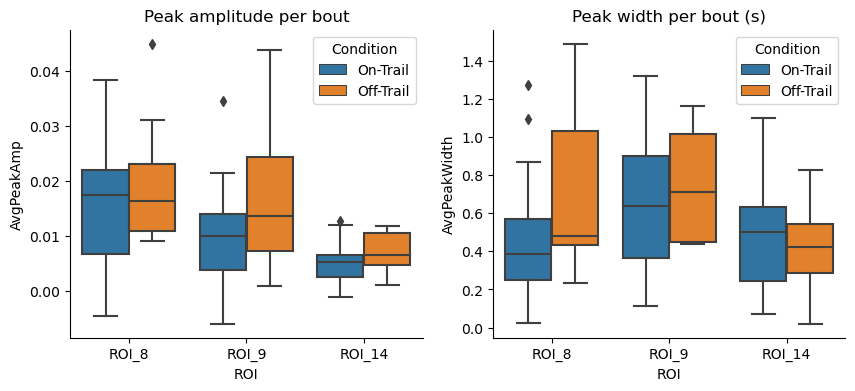

In [24]:
peak_stats = {'ROI': [], 'Condition': [], 'AvgPeakAmp': [], 'AvgPeakWidth': []}
for roi in ['ROI_8','ROI_9','ROI_14']:
    for condition, starts, ends in [('On-Trail', on_starts, on_ends),
                                    ('Off-Trail', off_starts, off_ends)]:
        for s, e in zip(starts, ends):
            sig = merged.iloc[s+2:e+2][roi].values
            threshold = np.mean(sig) + 2 * np.std(sig)
            peaks, props = find_peaks(sig, height=threshold, distance=fs_beh*0.5)
            heights = props.get('peak_heights', [])
            if len(peaks) > 0:
                widths = peak_widths(sig, peaks, rel_height=0.5)[0]
                avg_amp = np.mean(heights)
                avg_width = np.mean(widths / fs_beh)  # convert width to seconds
            else:
                avg_amp = np.nan
                avg_width = np.nan
            peak_stats['ROI'].append(roi)
            peak_stats['Condition'].append(condition)
            peak_stats['AvgPeakAmp'].append(avg_amp)
            peak_stats['AvgPeakWidth'].append(avg_width)
peak_stats_df = pd.DataFrame(peak_stats)


# Plot peak amplitude and width side by side
fig, axes = plt.subplots(1, 2, figsize=(10,4))
sns.boxplot(x="ROI", y="AvgPeakAmp", hue="Condition", data=peak_stats_df, ax=axes[0])
axes[0].set_title("Peak amplitude per bout")
sns.boxplot(x="ROI", y="AvgPeakWidth", hue="Condition", data=peak_stats_df, ax=axes[1])
axes[1].set_title("Peak width per bout (s)")
plt.show()


In [25]:
def build_example_segments(on_starts, on_ends, off_starts, off_ends,
                           n_on=2, n_off=2, offset=0):
    on_examples  = [(int(on_starts[i]), int(on_ends[i]))
                    for i in range(offset, min(offset+n_on, len(on_starts)))]
    off_examples = [(int(off_starts[i]), int(off_ends[i]))
                    for i in range(offset, min(offset+n_off, len(off_starts)))]
    return on_examples, off_examples


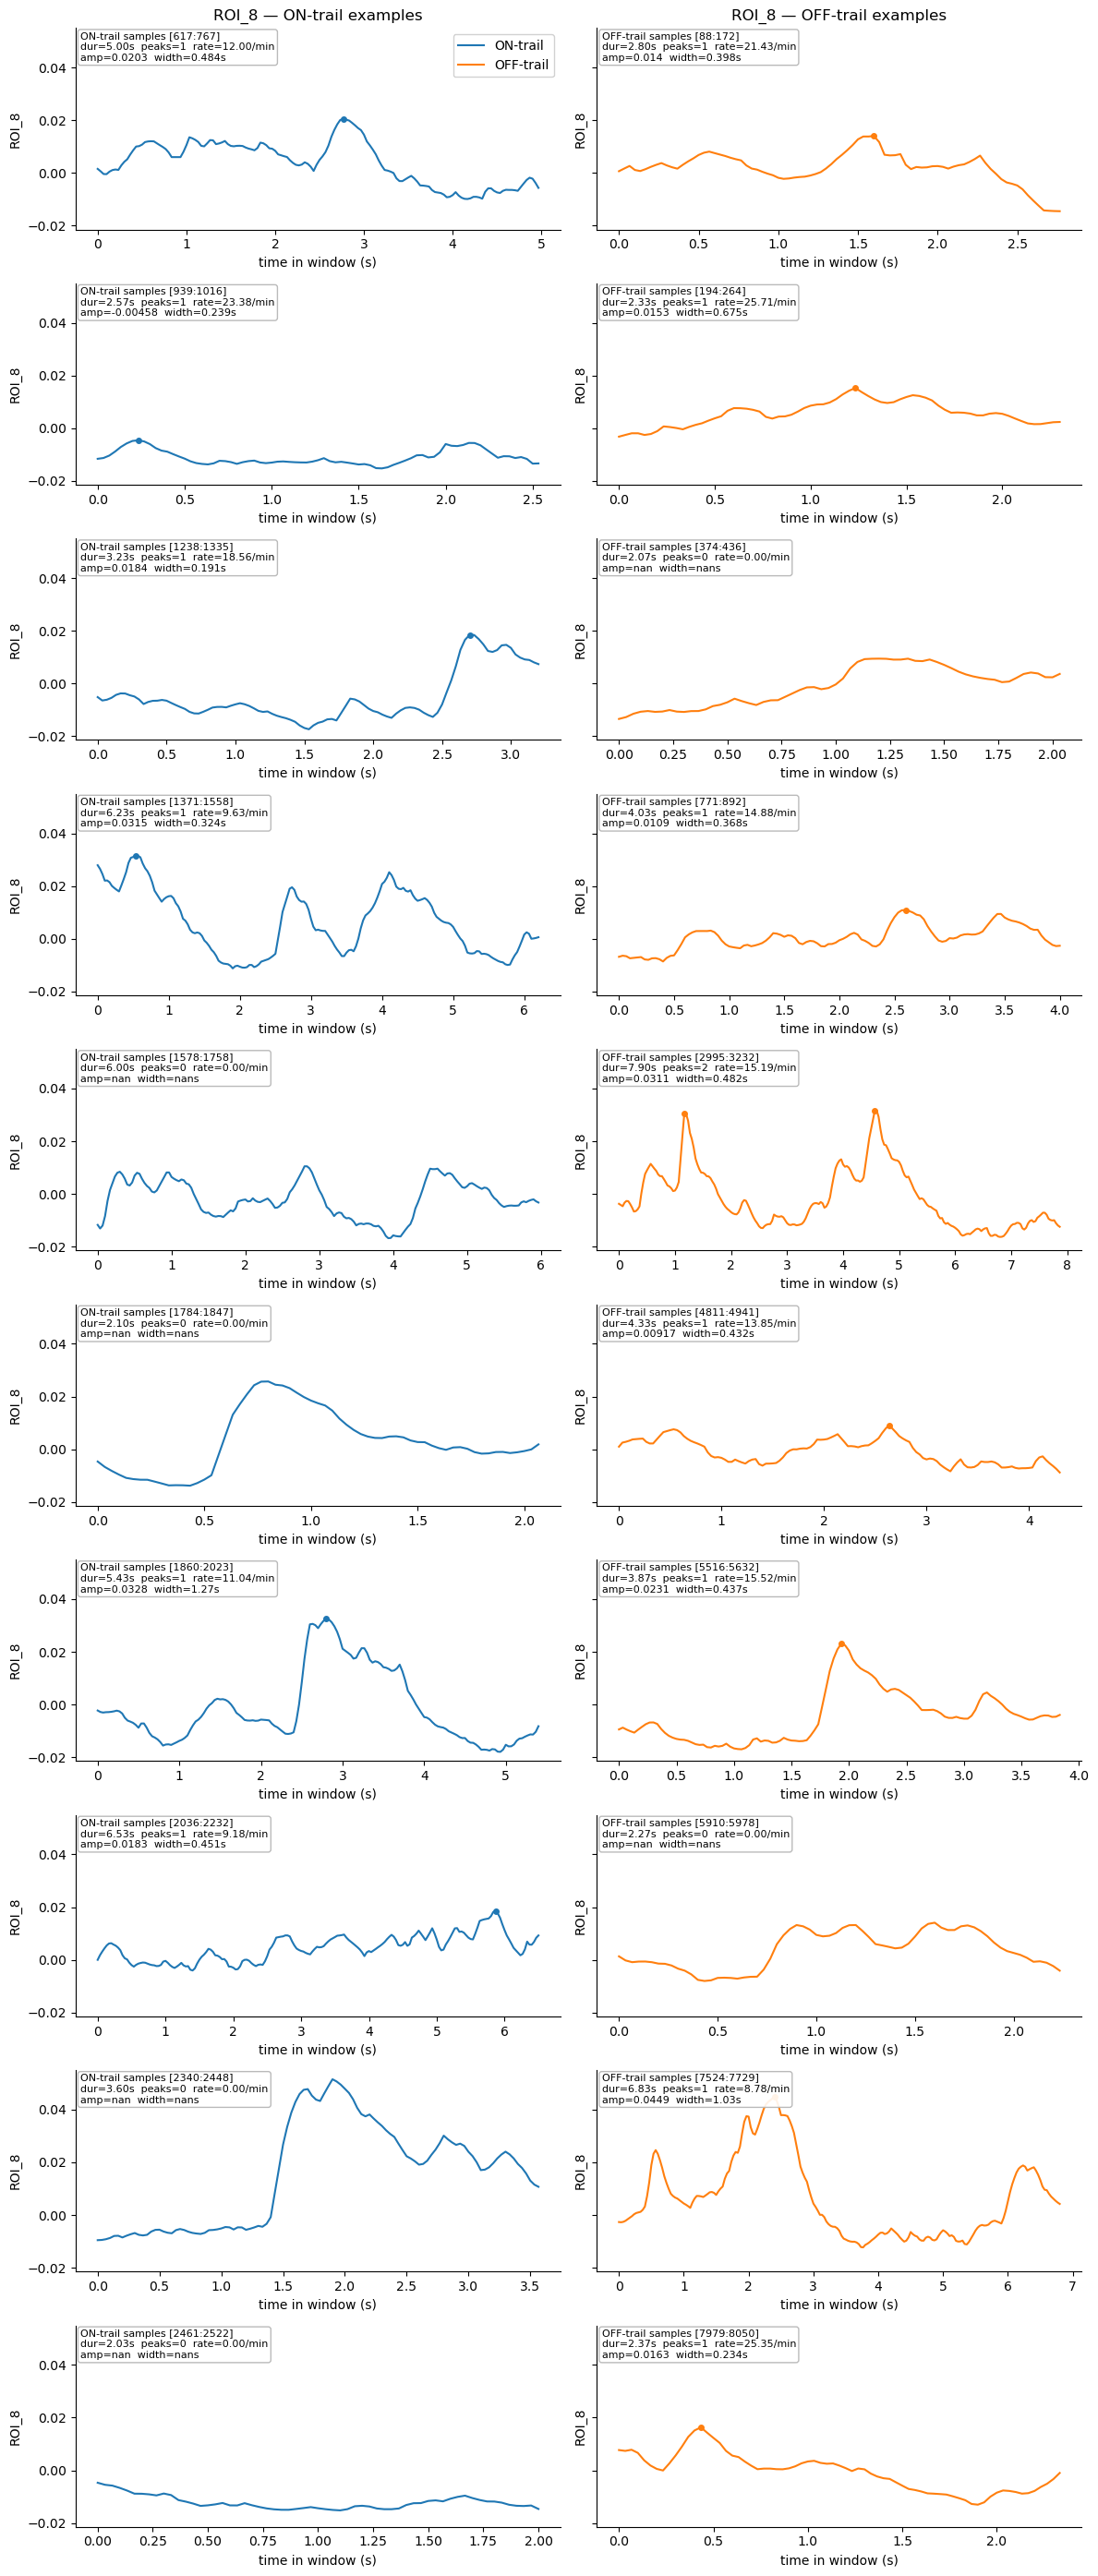

In [26]:
def _detect_peaks(sig, fs, thr=None, min_dist_s=0.5):
    if sig.size == 0 or not np.isfinite(sig).all():
        return np.array([]), np.array([]), np.array([])
    if thr is None:
        thr = float(np.nanmean(sig) + 2.0*np.nanstd(sig))
    distance = max(1, int(round(min_dist_s * fs)))
    peaks, props = find_peaks(sig, height=thr, distance=distance)
    heights = props.get('peak_heights', np.array([]))
    if peaks.size:
        widths_samp = peak_widths(sig, peaks, rel_height=0.5)[0]
        widths_s = widths_samp / float(fs)
    else:
        widths_s = np.array([])
    return peaks, heights, widths_s

def plot_bout_examples(
    merged: pd.DataFrame,
    roi: str,
    on_examples=None,   # list of (start_idx, end_idx) in samples
    off_examples=None,  # list of (start_idx, end_idx) in samples
    fs: float = fs_beh,
    min_dist_s: float = 0.5,
    sharey: bool = False,
):
    """
    Plot raw ROI traces for sample-index windows, mark peaks, and show per-window stats.
    Each row shows an ON-trail example (left) and an OFF-trail example (right), if provided.
    """
    if roi not in merged.columns:
        raise KeyError(f"{roi} not found in merged.columns")


    on_examples  = on_examples  or []
    off_examples = off_examples or []

    n_rows = max(len(on_examples), len(off_examples))
    if n_rows == 0:
        raise ValueError("Provide at least one (start,end) window in samples.")

    n_cols = 2 if (len(on_examples) or len(off_examples)) else 1
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 2.8*n_rows), sharey=sharey)
    if n_rows == 1 and n_cols == 1:
        axes = np.array([[axes]])
    elif n_rows == 1:
        axes = np.array([axes])

    def plot_one(ax, label, s, e, color):
        sig = merged[roi].iloc[int(s):int(e)].to_numpy()
        tt_rel = np.arange(sig.size) / fs

        peaks, heights, widths_s = _detect_peaks(sig, fs, thr=None, min_dist_s=min_dist_s)
        dur_s = sig.size / fs if sig.size else 0.0
        n_pk = int(peaks.size)
        rate = (n_pk / dur_s * 60.0) if dur_s > 0 else np.nan
        mean_amp = float(np.nanmean(heights)) if heights.size else np.nan
        mean_w   = float(np.nanmean(widths_s)) if widths_s.size else np.nan

        ax.plot(tt_rel, sig, color=color, lw=1.5, label=label)
        if n_pk:
            ax.plot(tt_rel[peaks], sig[peaks], 'o', color=color, ms=4)

        txt = (f"{label} samples [{s}:{e}]\n"
               f"dur={dur_s:.2f}s  peaks={n_pk}  rate={rate:.2f}/min\n"
               f"amp={mean_amp:.3g}  width={mean_w:.3g}s")
        ax.text(0.01, 0.98, txt, transform=ax.transAxes, ha='left', va='top',
                fontsize=8, bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9))

        ax.set_ylabel(roi)
        ax.set_xlabel("time in window (s)")

    for r in range(n_rows):
        if n_cols == 2:
            ax_on, ax_off = axes[r]
        else:
            ax_on = axes[r][0]

        if r < len(on_examples):
            s, e = on_examples[r]
            plot_one(ax_on, "ON-trail", s, e, color='tab:blue')
        else:
            if n_cols == 2:
                ax_on.axis('off')

        if n_cols == 2:
            if r < len(off_examples):
                s, e = off_examples[r]
                plot_one(ax_off, "OFF-trail", s, e, color='tab:orange')
            else:
                ax_off.axis('off')

    if n_cols == 2:
        axes[0,0].set_title(f'{roi} — ON-trail examples')
        axes[0,1].set_title(f'{roi} — OFF-trail examples')
    else:
        axes[0,0].set_title(f'{roi} — examples')

    handles, labels = [], []
    for row in axes:
        for ax in np.atleast_1d(row):
            h, l = ax.get_legend_handles_labels()
            handles += h; labels += l
    if handles:
        seen = set(); H = []; L = []
        for h, l in zip(handles, labels):
            if l not in seen:
                seen.add(l); H.append(h); L.append(l)
        axes[0,0].legend(H, L, loc='upper right', framealpha=0.9)

    plt.tight_layout()
    plt.show()
    
on_examples, off_examples = build_example_segments(on_starts, on_ends, off_starts, off_ends, n_on=10, n_off=10, offset=0)
plot_bout_examples(merged, roi='ROI_8', on_examples=on_examples, off_examples=off_examples, fs=fs_beh, sharey=True)


#### Event Triggered Averages

##### At corrective event onsets

Corrective ETAs — mean and std across events:
   ROI  n_events  pre_mean  pre_std  post_mean  post_std
 ROI_8        33  0.001319 0.007498  -0.000783  0.007905
 ROI_9        33  0.001430 0.006899  -0.001312  0.006659
ROI_14        33  0.000345 0.002669  -0.000472  0.002326


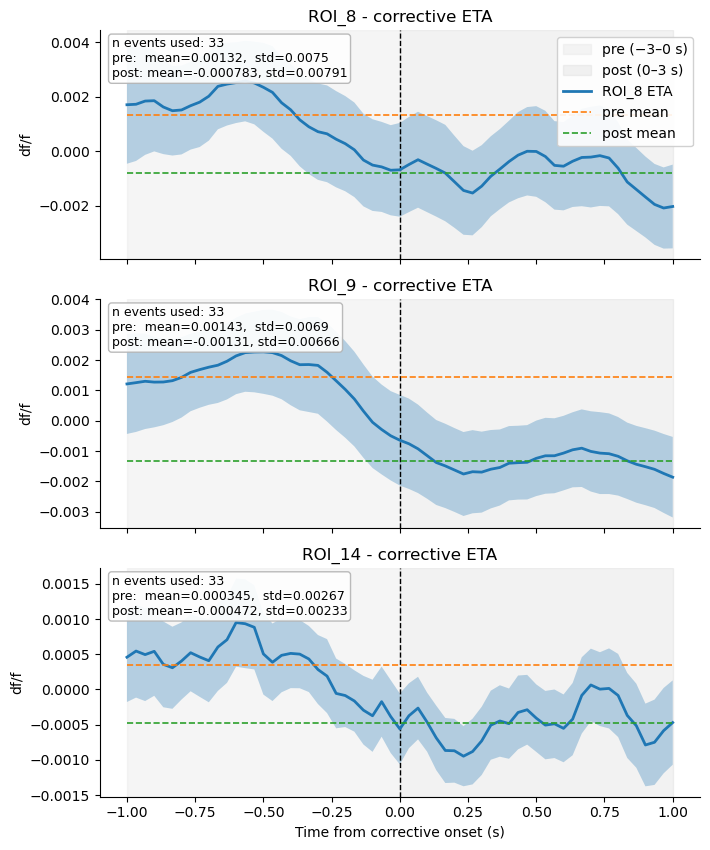

In [27]:

def stack_windows_raw(x, centers, pre_samp, post_samp):
    """Return raw windows [n_events, T]; drop windows that hit edges or contain NaNs."""
    X = []
    for c in centers:
        if c - pre_samp < 0 or c + post_samp >= len(x):
            continue
        seg = x[c-pre_samp:c+post_samp+1]
        if np.any(~np.isfinite(seg)):
            continue
        X.append(seg)
    return np.array(X) if len(X) else np.empty((0, pre_samp+post_samp+1))

# --- params / data ---
fs = fs_beh
pre_s, post_s = 1.0, 1.0
pre_n, post_n = int(pre_s*fs), int(post_s*fs)
time = np.linspace(-pre_s, post_s, pre_n + post_n + 1)
rois = ['ROI_8','ROI_9','ROI_14']

# corrective onsets
corr_starts, corr_ends  = run_spans(merged['corrective'].to_numpy())

# --- build ETAs on RAW signals (no baseline subtraction) ---
eta_raw = {roi: None for roi in rois}
summary_rows = []

pre_mask  = time < 0
post_mask = time >= 0   # (0 to +3 s)

for roi in rois:
    sig = merged[roi].to_numpy()
    X = stack_windows_raw(sig, corr_starts, pre_n, post_n)  # [n_events, T]
    n_used = X.shape[0]

    if n_used == 0:
        eta_raw[roi] = dict(mu=None, se=None, n=0,
                            pre_mean=np.nan, pre_std=np.nan,
                            post_mean=np.nan, post_std=np.nan)
        summary_rows.append({'ROI': roi, 'n_events': 0,
                             'pre_mean': np.nan, 'pre_std': np.nan,
                             'post_mean': np.nan, 'post_std': np.nan})
        continue

    mu = X.mean(axis=0)
    se = X.std(axis=0, ddof=1) / np.sqrt(n_used)

    # per-event means in pre/post windows
    pre_per_event  = X[:, pre_mask].mean(axis=1)
    post_per_event = X[:, post_mask].mean(axis=1)

    pre_mean  = pre_per_event.mean()
    pre_std   = pre_per_event.std(ddof=1)
    post_mean = post_per_event.mean()
    post_std  = post_per_event.std(ddof=1)

    eta_raw[roi] = dict(mu=mu, se=se, n=n_used,
                        pre_mean=pre_mean, pre_std=pre_std,
                        post_mean=post_mean, post_std=post_std)

    summary_rows.append({'ROI': roi, 'n_events': n_used,
                         'pre_mean': pre_mean, 'pre_std': pre_std,
                         'post_mean': post_mean, 'post_std': post_std})

# print summary table
summary_df = pd.DataFrame(summary_rows)
print("Corrective ETAs — mean and std across events:")
print(summary_df.to_string(index=False))

# --- plot with annotations ---
fig, axes = plt.subplots(len(rois), 1, sharex=True, figsize=(7.2, 8.6))
if len(rois) == 1: axes = [axes]

for ax, roi in zip(axes, rois):
    d = eta_raw[roi]
    # shading for pre/post windows
    ax.axvspan(-pre_s, 0,  color='0.9', alpha=0.4, label='pre (−3–0 s)')
    ax.axvspan(0,  post_s, color='0.8', alpha=0.25, label='post (0–3 s)')
    ax.axvline(0, color='k', ls='--', lw=1)

    if d["mu"] is not None:
        ax.plot(time, d["mu"], lw=2.0, label=f'{roi} ETA')
        ax.fill_between(time, d["mu"]-d["se"], d["mu"]+d["se"], alpha=0.3)
        # horizontal lines at pre/post means (across events)
        ax.hlines(d['pre_mean'],  time[0], time[-1], colors='C1', linestyles='--', lw=1.2, label='pre mean')
        ax.hlines(d['post_mean'], time[0], time[-1], colors='C2', linestyles='--', lw=1.2, label='post mean')

        txt = (f"n events used: {d['n']}\n"
               f"pre:  mean={d['pre_mean']:.3g},  std={d['pre_std']:.3g}\n"
               f"post: mean={d['post_mean']:.3g}, std={d['post_std']:.3g}")
    else:
        txt = "n events used: 0\npre/post: n/a"

    ax.text(0.02, 0.97, txt, ha='left', va='top',
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9))

    ax.set_ylabel('df/f')
    ax.set_title(f'{roi} - corrective ETA')

handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper right', framealpha=0.9)
axes[-1].set_xlabel('Time from corrective onset (s)')
plt.tight_layout()
plt.show()


##### Stationary events

Stationary ETAs — mean and std across events (RAW signal):
   ROI  n_events  pre_mean  pre_std  post_mean  post_std
 ROI_8        16  0.001809 0.010757   0.004859  0.013695
 ROI_9        16  0.001265 0.007137   0.003962  0.010775
ROI_14        16  0.000084 0.002688   0.001181  0.003092


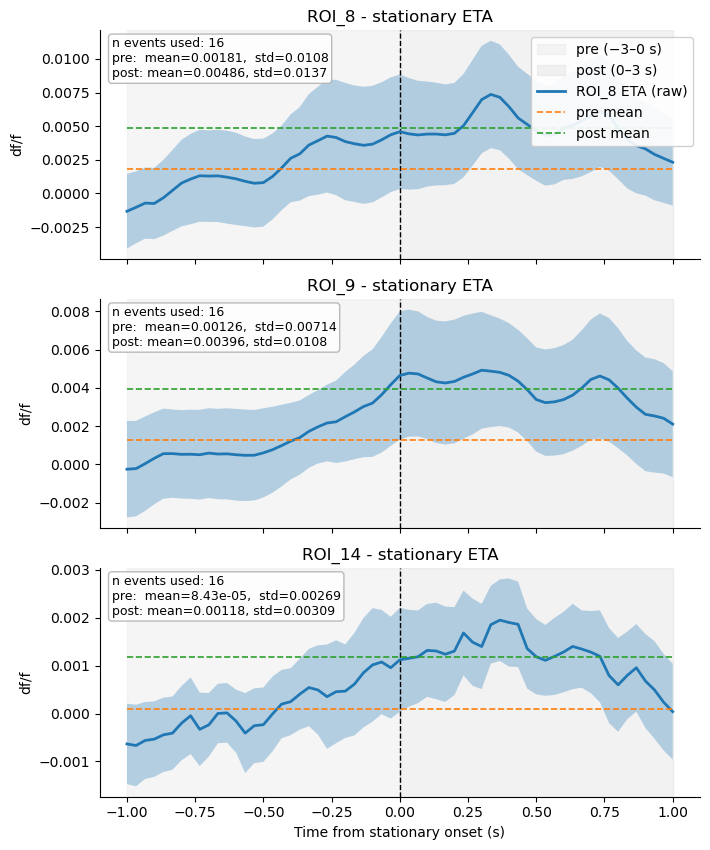

In [32]:
# --- params / data ---
fs = fs_beh
pre_s, post_s = 1.0, 1.0
pre_n, post_n = int(pre_s*fs), int(post_s*fs)
time = np.linspace(-pre_s, post_s, pre_n + post_n + 1)
rois = ['ROI_8','ROI_9','ROI_14']

# corrective onsets
corr_starts, corr_ends  = run_spans(merged['stationary'].to_numpy())

# --- build ETAs on RAW signals (no baseline subtraction) ---
eta_raw = {roi: None for roi in rois}
summary_rows = []

pre_mask  = time < 0
post_mask = time >= 0   # (0 to +3 s)

for roi in rois:
    sig = merged[roi].to_numpy()
    X = stack_windows_raw(sig, corr_starts, pre_n, post_n)  # [n_events, T]
    n_used = X.shape[0]

    if n_used == 0:
        eta_raw[roi] = dict(mu=None, se=None, n=0,
                            pre_mean=np.nan, pre_std=np.nan,
                            post_mean=np.nan, post_std=np.nan)
        summary_rows.append({'ROI': roi, 'n_events': 0,
                             'pre_mean': np.nan, 'pre_std': np.nan,
                             'post_mean': np.nan, 'post_std': np.nan})
        continue

    mu = X.mean(axis=0)
    se = X.std(axis=0, ddof=1) / np.sqrt(n_used)

    # per-event means in pre/post windows
    pre_per_event  = X[:, pre_mask].mean(axis=1)
    post_per_event = X[:, post_mask].mean(axis=1)

    pre_mean  = pre_per_event.mean()
    pre_std   = pre_per_event.std(ddof=1)
    post_mean = post_per_event.mean()
    post_std  = post_per_event.std(ddof=1)

    eta_raw[roi] = dict(mu=mu, se=se, n=n_used,
                        pre_mean=pre_mean, pre_std=pre_std,
                        post_mean=post_mean, post_std=post_std)

    summary_rows.append({'ROI': roi, 'n_events': n_used,
                         'pre_mean': pre_mean, 'pre_std': pre_std,
                         'post_mean': post_mean, 'post_std': post_std})

# print summary table
summary_df = pd.DataFrame(summary_rows)
print("Stationary ETAs — mean and std across events (RAW signal):")
print(summary_df.to_string(index=False))

# --- plot with annotations ---
fig, axes = plt.subplots(len(rois), 1, sharex=True, figsize=(7.2, 8.6))
if len(rois) == 1: axes = [axes]

for ax, roi in zip(axes, rois):
    d = eta_raw[roi]
    # shading for pre/post windows
    ax.axvspan(-pre_s, 0,  color='0.9', alpha=0.4, label='pre (−3–0 s)')
    ax.axvspan(0,  post_s, color='0.8', alpha=0.25, label='post (0–3 s)')
    ax.axvline(0, color='k', ls='--', lw=1)

    if d["mu"] is not None:
        ax.plot(time, d["mu"], lw=2.0, label=f'{roi} ETA (raw)')
        ax.fill_between(time, d["mu"]-d["se"], d["mu"]+d["se"], alpha=0.3)
        # horizontal lines at pre/post means (across events)
        ax.hlines(d['pre_mean'],  time[0], time[-1], colors='C1', linestyles='--', lw=1.2, label='pre mean')
        ax.hlines(d['post_mean'], time[0], time[-1], colors='C2', linestyles='--', lw=1.2, label='post mean')

        txt = (f"n events used: {d['n']}\n"
               f"pre:  mean={d['pre_mean']:.3g},  std={d['pre_std']:.3g}\n"
               f"post: mean={d['post_mean']:.3g}, std={d['post_std']:.3g}")
    else:
        txt = "n events used: 0\npre/post: n/a"

    ax.text(0.02, 0.97, txt, ha='left', va='top',
            transform=ax.transAxes, fontsize=9,
            bbox=dict(boxstyle='round,pad=0.25', fc='white', ec='0.7', alpha=0.9))

    ax.set_ylabel('df/f')
    ax.set_title(f'{roi} - stationary ETA')

# tidy legend once
handles, labels = axes[0].get_legend_handles_labels()
axes[0].legend(handles, labels, loc='upper right', framealpha=0.9)
axes[-1].set_xlabel('Time from stationary onset (s)')
plt.tight_layout()
plt.show()


##### Trail turns

Odor Shift ETAs — pre/post stats by condition (RAW):
   ROI Condition  n_events  pre_mean  pre_std  post_mean  post_std
 ROI_8  On-trail        19 -0.002105 0.011213  -0.002103  0.006585
 ROI_8 Off-trail        24  0.001126 0.010323  -0.001598  0.008831
 ROI_9  On-trail        19 -0.002742 0.006964  -0.002676  0.005657
 ROI_9 Off-trail        24 -0.000009 0.007435  -0.001720  0.007222
ROI_14  On-trail        19  0.000362 0.003221   0.000297  0.002994
ROI_14 Off-trail        24 -0.000008 0.002844  -0.000258  0.002792


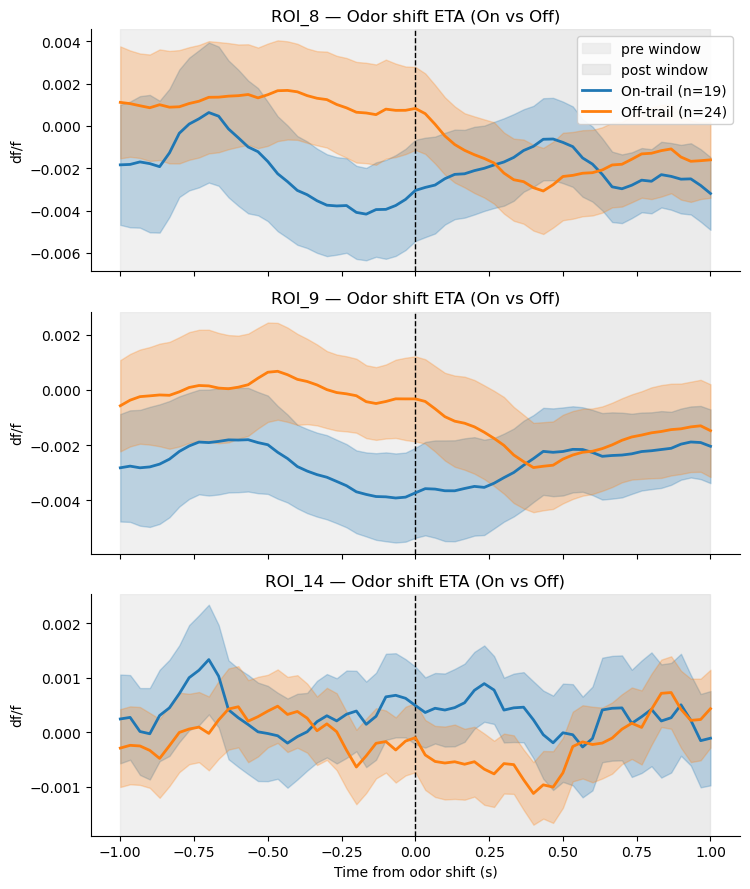

In [35]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# assumes you already have:
# fs_beh, merged, run_spans, stack_windows_raw
fs = fs_beh
pre_s, post_s = 1.0, 1.0
pre_n, post_n = int(pre_s*fs), int(post_s*fs)
time = np.linspace(-pre_s, post_s, pre_n + post_n + 1)
rois = ['ROI_8','ROI_9','ROI_14']

# odor-shift onsets (point events)
evt_starts, evt_ends = run_spans(merged['odor_shift_event'].to_numpy())

# classify each event start as on/off trail at the event time
evt_on_mask = []
for i in evt_starts:
    # guard NaNs → treat as off by default
    val = merged['on_trail'].iloc[i]
    evt_on_mask.append(bool(val) if pd.notna(val) else False)
evt_on_mask = np.array(evt_on_mask, dtype=bool)

cond_indices = {
    'On-trail' : evt_starts[evt_on_mask],
    'Off-trail': evt_starts[~evt_on_mask],
}

# helper to compute ETA stats for a set of centers
def eta_stats_for(sig, centers, pre_n, post_n, time):
    X = stack_windows_raw(sig, centers, pre_n, post_n)  # [n_events, T]
    if X.size == 0:
        return dict(n=0, mu=None, se=None, pre_mean=np.nan, pre_std=np.nan,
                    post_mean=np.nan, post_std=np.nan)
    n_used = X.shape[0]
    mu = X.mean(axis=0)
    se = X.std(axis=0, ddof=1) / np.sqrt(n_used)
    pre_mask  = time < 0
    post_mask = time >= 0
    pre_vals  = X[:, pre_mask].mean(axis=1)
    post_vals = X[:, post_mask].mean(axis=1)
    return dict(n=n_used, mu=mu, se=se,
                pre_mean=pre_vals.mean(),  pre_std=pre_vals.std(ddof=1),
                post_mean=post_vals.mean(), post_std=post_vals.std(ddof=1))

# compute ETAs per ROI × condition
summary_rows = []
etas = {roi: {} for roi in rois}
for roi in rois:
    sig = merged[roi].to_numpy()
    for cond, centers in cond_indices.items():
        et = eta_stats_for(sig, centers, pre_n, post_n, time)
        etas[roi][cond] = et
        summary_rows.append({
            'ROI': roi, 'Condition': cond, 'n_events': et['n'],
            'pre_mean': et['pre_mean'], 'pre_std': et['pre_std'],
            'post_mean': et['post_mean'], 'post_std': et['post_std'],
        })

summary_df = pd.DataFrame(summary_rows)
print("Odor Shift ETAs — pre/post stats by condition (RAW):")
print(summary_df.to_string(index=False))

# ---- plot: overlay On vs Off on the same axes for each ROI ----
colors = {'On-trail': 'C0', 'Off-trail': 'C1'}
fig, axes = plt.subplots(len(rois), 1, sharex=True, figsize=(7.6, 9.0))
if len(rois) == 1:
    axes = [axes]

for ax, roi in zip(axes, rois):
    # background windows
    ax.axvspan(-pre_s, 0,  color='0.90', alpha=0.6, label='pre window')
    ax.axvspan(0,  post_s, color='0.85', alpha=0.5, label='post window')
    ax.axvline(0, color='k', ls='--', lw=1)

    for cond in ['On-trail', 'Off-trail']:
        d = etas[roi][cond]
        if d['mu'] is None:
            continue
        c = colors[cond]
        ax.plot(time, d['mu'], color=c, lw=2.0, label=f'{cond} (n={d["n"]})')
        ax.fill_between(time, d['mu']-d['se'], d['mu']+d['se'], color=c, alpha=0.25)

    ax.set_ylabel('df/f')
    ax.set_title(f'{roi} — Odor shift ETA (On vs Off)')

# tidy legend
handles, labels = axes[0].get_legend_handles_labels()
# dedupe labels
seen = set(); H=[]; L=[]
for h,l in zip(handles, labels):
    if l not in seen:
        seen.add(l); H.append(h); L.append(l)
axes[0].legend(H, L, loc='upper right', framealpha=0.9)

axes[-1].set_xlabel('Time from odor shift (s)')
plt.tight_layout()
plt.show()
